<a href="https://colab.research.google.com/github/Yuri-Nassar/mat_tree/blob/master/TCC_multiAspectClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libs

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import math
from copy import deepcopy
from collections import namedtuple, defaultdict
import itertools
import json

from graphviz import Digraph
import networkx as nx
# import plotly.io as pio
from IPython.display import display#, display_html, HTML
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
sns.set(rc={'figure.figsize':(10.7,7.27)})

In [2]:
# dataset path
try:
  from google.colab import drive
  !pip install plotly==5.24.1 -q
  drive.mount('/content/drive')
  %cd drive/Othercomputers/"Meu laptop"/mat_tree
except:
  print("Running locally.")

import plotly.graph_objects as go

dataset_path = "datasets"

Mounted at /content/drive
/content/drive/Othercomputers/Meu laptop/mat_tree


# Load dataset

In [3]:
dataset = 'basometro'
dataset_version = 'basometro_v2.csv'

df = pd.read_csv(dataset_path+"/"+dataset+"/"+dataset_version, encoding='utf-8', parse_dates=['data'])
df.head()

,UF,voto,orientacaoGoverno,anoProposicao,anoVotacao,tipoProposicao,governo,parlamentar,data,idVotacao,...,alinhamento,esp_pol_partido,governo_alinhamento,partido_voto_sim_%,partido_voto_nao_%,partido_voto_abstencao_%,partido_voto_obstrucao_%,partido_voto_ausente_%,orientacao_partido_voto,alinhamento_candidato
0,PR,Sim,Sim,2002,2003,MSC,Lula_1,Abelardo Lupion,2003-02-25 18:54:00,25-2-2003.18.54.736,...,votou com o governo,Centro-direita,Lula_1/votou com o governo,55.67,0.00,0.0,0.0,44.33,Sim,votou com o partido
1,PR,Sim,Sim,2002,2003,MPV,Lula_1,Abelardo Lupion,2003-03-18 19:30:00,18-3-2003.19.30.742,...,votou com o governo,Centro-direita,Lula_1/votou com o governo,52.58,13.40,0.0,0.0,34.02,Sim,votou com o partido
2,PR,Sim,Não,1996,2003,PL,Lula_1,Abelardo Lupion,2003-03-19 18:37:00,19-3-2003.18.37.743,...,votou contra o governo,Centro-direita,Lula_1/votou contra o governo,53.61,4.12,0.0,0.0,42.27,Sim,votou com o partido
3,PR,Sim,Não,2002,2003,MPV,Lula_1,Abelardo Lupion,2003-03-26 19:16:00,26-3-2003.19.16.746,...,votou contra o governo,Centro-direita,Lula_1/votou contra o governo,59.79,5.15,0.0,0.0,35.05,Sim,votou com o partido
4,PR,Sim,Não,2003,2003,MPV,Lula_1,Abelardo Lupion,2003-04-08 18:02:00,8-4-2003.18.02.754,...,votou contra o governo,Centro-direita,Lula_1/votou contra o governo,55.67,6.19,0.0,0.0,38.14,Sim,votou com o partido


In [5]:
df['governo'].unique()

array(['Lula_1', 'Lula_2', 'Dilma_1', 'Temer_1', 'Dilma_2', 'Bolsonaro_1'],
      dtype=object)

- Filter by government

You can select a specific government to run the clustering method.

In [6]:
df_bkp = df.copy()
name_test_government = 'Bolsonaro_1' # all_governments, Bolsonaro_1, Dilma_1, Dilma_2, Temer_1

if name_test_government in df['governo'].unique():
  df = df[df['governo'] == name_test_government]
elif name_test_government == 'all_governments':
  df = df
else:
  print("Government not found!")

# Extra digraph

Auxiliary functions to enrich the Digraph visualization.

## Color node digraph

In [7]:
def check_alignment(cluster_id, clusters):
  df_cluster = clusters[cluster_id]
  tot_votes = len(df_cluster)
  mask_not_inline = ((df_cluster['alinhamento'] == 'votou contra o governo') | (df_cluster['voto'] == 'Obstrução'))

  n_votes_not_inline = len(df_cluster[mask_not_inline])
  prop_not_inline = round(n_votes_not_inline/tot_votes, 4)

  if prop_not_inline >= 0.5:
    return False, prop_not_inline
  else:
    return True, round(1-prop_not_inline, 4)


# check_alignment('Lvl 3 - 2', TreeNode.df_leaves.copy())

In [8]:
# plot_sankey_flow(TreeNode.df_dict.copy(), df.copy(), ['governo', 'alinhamento', 'voto', 'esp_pol_partido', 'partido', 'tipoProposicao'], node_id, strat_split,
# plot_sankey_flow(TreeNode.df_dict.copy(), df.copy(), ['governo', 'alinhamento', 'voto', 'esp_pol_partido', 'partido', 'tipoProposicao'], node_id, strat_split,
def interpolate_color(value: float, support:bool):
  """Interpolate between two colors based on a value between 0 and 1."""

  adjusted_value = (value-0.5)*2 # bring the value close to 0.5 and then scale
  start_color = 'ffffff' # white
  start_color = [int(start_color[i:i+2], 16) for i in (0, 2, 4)]

  if support:
      end_color = '0E48A0'
      end_color = [int(end_color[i:i+2], 16) for i in (0, 2, 4)] # blue
  else:
      end_color = 'ff0000'
      end_color = [int(end_color[i:i+2], 16) for i in (0, 2, 4)] # red

  interpolated_color = [ int(start_color[i] + (end_color[i] - start_color[i]) * adjusted_value) for i in range(3) ]
  return '#{:02x}{:02x}{:02x}'.format(*interpolated_color)

In [9]:
def create_node(graph, node_name, color):
  """ Create a digraph node with color.
      Parameters:

  """

  graph.node(node_name, node_name, style='filled', fillcolor=color)

In [10]:
def create_color_node(cluster_id, graphTree, node_name):
  support, value = check_alignment(cluster_id, TreeNode.df_leaves)
  color = interpolate_color(value, support)
  # print(f"Cluster:{cluster_id}; Support: {support}; Value: {value}. Color: {color}")
  create_node(graphTree, node_name, color)

## Include majority info node

In [13]:
def get_major_info_cluster(cluster_id:str, df_clusters:dict):
  """ Method to get the party and proposition that are majority in a cluster
      regarding the support type.
  """

  df_cluster = df_clusters[cluster_id].copy()
  major_party = ""
  major_proposition = ""

  support, prop_value = check_alignment(cluster_id, df_clusters)
  mask_not_inline = ((df_cluster['alinhamento'] == 'votou contra o governo') | (df_cluster['voto'] == 'Obstrução'))

  if support:
    df_inline = df_cluster[~mask_not_inline]
    major_party = df_inline['partido'].value_counts().idxmax()
    major_proposition = df_inline['tipoProposicao'].value_counts().idxmax()
  else:
    df_not_inline = df_cluster[mask_not_inline]
    major_party = df_not_inline['partido'].value_counts().idxmax()
    major_proposition = df_not_inline['tipoProposicao'].value_counts().idxmax()

  return f"[{major_party} & {major_proposition}]\n{'Support' if support else 'Opposite'}={str(round(prop_value*100,2))}%"

In [14]:
#get_major_info_cluster(cluster_id='Lvl 3 - 2', df_clusters=TreeNode.df_leaves.copy())

# Algorithm

We recommend to run on Collab env to bypass local configurations on the machine. We also provide extra visual analysis with widgets, therefore, complementary functions are give bellow.

### Sankey

In [15]:
def sankey(cls, label, value):
  """
    Creates a sankey diagram from class dataset. Sankey diagram is a type of
    flow diagram in which the width of the arrows is proportional to the
    flow rate.
  """
  
  ### give an unique id for labels since it can repeat
  label_to_id = {}
  id = 0
  for k, v in label.items():
    for i in range(len(v)):
      label_to_id[v[i]] = id
      id+=1
  
  ## source-target-count
  source = []
  target = []
  count = []
  for k, v in label.items():
    id_next_node = 0
    for label_name in v:
      counter = 0
      for i in cls.nodeLabel[k+1]:
        if (counter <= 1) & (label_name.split('#')[0] != 'c'):
          source.append(label_name)
          target.append(label[k+1][id_next_node])
          count.append(value[k][id_next_node])
          id_next_node+=1
          counter+=1
        else:
          break

  data_link = {'source':source,
              'target':target,
              'count':count}
  

  df_source_target = pd.DataFrame(data_link, columns=['source','target','count'])
  df_source_target = df_source_target.replace({'source':label_to_id, 'target':label_to_id})

  label = list(itertools.chain.from_iterable(label.values()))
  value = list(itertools.chain.from_iterable(value.values()))
  source = [val for val in cls.source for _ in (0, 1)]
  target = [tar for tar in range(1, len(source) + 1)]

  link = dict(source=df_source_target['source'].values, target=df_source_target['target'],
              value=df_source_target['count'])

  def get_labels(raw_labels):
    labels = []
    for i in range(len(raw_labels)):
      tmp = raw_labels[i]
      try:
        labels.append(tmp.split('/')[0]+"<br>"+tmp.split('/')[1])
      except:
        labels.append(tmp)
    return labels

  node = dict(label=get_labels(list(label_to_id.keys())), pad=15, thickness=5)

  data = go.Sankey(link=link, node=node
                   ,arrangement='snap'
                  #  ,orientation='h'
                   ,valueformat = ".0f",)
  plt.figure(figsize=(10, 6))
  fig = go.FigureWidget(data=data)
  # fig.update_layout(title_text="Basic Sankey Diagram", font_size=10,plot_bgcolor='black',
  #                   paper_bgcolor='black',
  #                   width=500, height=500)
  fig.update_layout(width=1000, height=650)
  fig.show()

### EDA

In [16]:
def eda(cls, dataset, feature, usr=None):
  """
  Exploratory Data Analysis. It generates a plot bar of a given feature of
  a given dataset and a given user.

  Parameters
  ----------
  dataset : pandas.DataFrame
    Dataset of trajectories of a given cluster.
  feature : str
    Feature or Aspect intended for EDA.
  user : int
    User label in a given cluster.
  """
  idx = dataset.index

  df_total = df.copy()
  df1 = df[df.tid.isin(idx)]

  if usr is not None and usr is not 'ALL':
    df_total = df_total[df_total.label == usr]
    df1 = df1[df1.label == usr]


  df_total.reset_index(inplace=True)
  df1.reset_index(inplace=True)

  place_type_abs = df_total[feature]
  place_type = df1[feature]


  ''' Frequency per cluster '''
  values = np.sort(np.unique(place_type_abs))
  freq = np.zeros(len(values))
  ind = 0
  for i in values:
      counter = 0
      for j in range(0,len(place_type)):
          if(place_type[j] == i):
            counter = counter + 1
      freq[ind] = counter
      ind = ind + 1

  ''' Absolute frequency '''
  values_abs = np.sort(np.unique(place_type_abs))
  freq_abs = np.zeros(len(values_abs))
  ind_abs = 0
  for k in values_abs:
      counter = 0
      for l in range(0,len(place_type_abs)):
          if(place_type_abs[l] == k):
            counter = counter + 1
      freq_abs[ind_abs] = counter
      ind_abs = ind_abs + 1

  relative = []
  for i in range(len(freq)):
    relative.append(f'{(freq[i]/freq_abs[i])*100}')

  fig= plt.figure(figsize=(15,5))
  ax = plt.gca()


  y_pos = np.arange(len(values))
  plt.xticks(y_pos, values)
  plt.bar(y_pos, freq)
  plt.xticks(fontsize=10, rotation='vertical')
  plt.yticks(fontsize=10)
  plt.xlabel("Aspect values",fontsize = 15)
  plt.ylabel("Frequency", fontsize = 15)
  plt.title(f"Relative frequency for aspect '{feature}'")

  for i, p in enumerate(ax.patches):
      ax.text(p.get_x() + p.get_width()/2., p.get_height(), f'{int(p.get_height())} ({relative[i]:.4}%)',
              fontsize=10, color='black', ha='center', va='bottom')

### EDA CORR

In [17]:
def eda_corr(cls, dataset, usr):
  """
  Exploratory Data Analysis. It generates a plot of correlation matrix of
  all features of a given dataset and a given user.

  Parameters
  ----------
  dataset : pandas.DataFrame
    Dataset of trajectories of a given cluster.
  user : int
    User label in a given cluster.
  """
  
  idx = dataset.index
  ds = df[df.tid.isin(idx)]

  if usr is not None:
    ds = ds[ds.label == usr]

  cols1   = df.columns.tolist()
  cols2 = TreeNode.useCol
  columns = list(set(cols1).difference(set(cols2)))

  ds = ds.drop(columns=columns)
  corr = pd.get_dummies(ds)
  corr = corr.corr()

  plt.figure(figsize=(10, 4))
  plt.imshow(corr, cmap='Blues', interpolation='none', aspect='auto')
  plt.colorbar()
  plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
  plt.yticks(range(len(corr)), corr.columns);
  plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
  plt.grid(False)

### Entropy

In [18]:
def get_entropy(dataset):
  """
    Calculates the entropy value of a given dataset.

    Parameters
    ----------
    dataset : pandas.DataFrame
      Dataset of trajectories of a given cluster

    Returns
    -------
    Float
      Entropy value of a given cluster.
  """
  
  df1 = dataset.copy()
  entropy_dict = {}
  for e in df1['partido'].unique():
    num_traj = df1[df1['partido'] == e]['tid'].unique()
    entropy_dict[e] = len(num_traj)
  total = sum(entropy_dict.values())

  entropy_value = 0
  for key, value in entropy_dict.items():
    p = value/total
    entropy_value += p * math.log2(p)

  try:
    max_entropy = math.log2(len(df1['partido'].unique()))
    return -entropy_value/max_entropy
  except:
    return -entropy_value
  # return -entropy_value/max_entropy

### Similarity Matrix

In [19]:
def get_similarity_matrix(dataset, sim_measure):
    """
      Creates the distance matrix of the trajectories of a given cluster using
      the given similarity metric.

      Parameters
      ----------
      dataset : pandas.DataFrame
        Dataset of trajectories of a given cluster
      sim_measure : str
        Similarity metric [MUITAS, MSM, EDR, LCSS].

      Returns
      -------
      pandas.DataFrame
        A dataframe of [MUITAS, MSM, EDR, LCSS] similarity metric.
    """

    df_tid = dataset.tid.unique()
    cols = []
    # Select columns according to trajectories
    for e in df_tid:
        cols.append(str(e))

    df_aux = None
    sim_matrix = None
    if sim_measure == 'MUITAS':
        sm_file = dataset_path+"/"+dataset_version.split('_')[0]+"/muitas.csv"
        tmp = pd.read_csv(sm_file)
        cols2 = tmp.columns
        cols_intersec = list(set(cols).intersection(set(cols2)))
        sim_matrix = pd.read_csv(sm_file, usecols=cols_intersec)

    elif sim_measure == 'MSM':
        sm_file = dataset_path+"/"+dataset_version.split('_')[0]+"/msm.csv"
        tmp = pd.read_csv(sm_file)
        cols2 = tmp.columns
        cols_intersec = list(set(cols).intersection(set(cols2)))
        sim_matrix = pd.read_csv(sm_file, usecols=cols_intersec)

    elif sim_measure == 'EDR':
        sm_file = dataset_path+"/"+dataset_version.split('_')[0]+"/edr.csv"
        tmp = pd.read_csv(sm_file)
        cols2 = tmp.columns
        cols_intersec = list(set(cols).intersection(set(cols2)))
        sim_matrix = pd.read_csv(sm_file, usecols=cols_intersec)

    elif sim_measure == 'LCSS':
        sm_file = dataset_path+"/"+dataset_version.split('_')[0]+"/lcss.csv"
        tmp = pd.read_csv(sm_file)
        cols2 = tmp.columns
        cols_intersec = list(set(cols).intersection(set(cols2)))
        sim_matrix = pd.read_csv(sm_file, usecols=cols_intersec)

    df_aux = sim_matrix.copy()
    idx = []

    # Select rows according to trajectories
    for c in sim_matrix:
        idx.append(df_aux.columns.get_loc(c))
    sim_matrix = sim_matrix[sim_matrix.index.isin(idx)]

    del df_aux, df_tid, idx, cols, cols2, cols_intersec, tmp

    return sim_matrix.set_index(sim_matrix.columns)

### TreeNode

Class to create the tree and the embbeded widget visualization.

In [20]:
class TreeNode:
    """
      A class used to represent a node in a Tree.

      Attributes
      ----------
      TODO

      Methods
      -------
      set_level: Defines the cluster label.
      check_label: Method used to verify cluster aspect label in order to avoid
                   duplicate names in Sankey Diagram.
      sankey: Creates a sankey diagram from class dataset. Sankey diagram is a
              type of flow diagram in which the width of the arrows is
              proportional to the flow rate.
      eda: Exploratory Data Analysis. It generates a plot bar of a given feature of
            a given dataset and a given user.
      eda_corr: Exploratory Data Analysis. It generates a plot of correlation
                matrix of all features of a given dataset and a given user.
      get_similarity_matrix: Creates the distance matrix of the trajectories of
                             a given cluster using the given similarity metric.
      get_entropy: Calculates the entropy value of a given dataset.
      dashboard: Displays the result dashboard.
      show: Shows info about each cluster node.
      graphicTree: Shows info about each cluster node in the tree generated by Digraph
                  plot.
      dashTree: Method that calculates the frequency matrix and the clusters
                generated from the division of data based on a split criteria
                defined in the Tree constructor.

    """

    # Select option in dashboard
    SELECT = 'Select Node'
    ALL = 'ALL'
    HEATMAP = 'HEATMAP'

    # dict to store the threshold of each selected aspect to split the set of trajectories
    threshold_nodes = {}

    # Sankey diagram params
    label = defaultdict(list)
    value = defaultdict(list)
    source = []

    id_dict = defaultdict(list)
    id_list = []

    # Params to label tree nodes
    nodeNum, targetNum = -1, -1
    nodeLabel = defaultdict(list)

    # 1. Dictionary of all nodes dataframes
    # 2. Dictionary of all leaves nodes dataframes
    df_dict = {}
    df_leaves = {}

    ############################################################################
    # Frequency matrix for the initial dataset
    absolute_frequency_matrix = None
    relative = True

    ############################################################################
    temporario = 0
    clusters = 0
    dendrogram_dict = defaultdict(list)

    ############################################################################
    var_dict = {}
    id_iter = itertools.count()

    temp = {}

    ### Aspects (features) that user wanto to use on clustering analysis. ###
    # useCol = ['partido', 'alinhamento', 'orientacaoGoverno', 'voto', 'tipoProposicao', 'governo']# independents
    # useCol = ['partido', 'governo_alinhamento', 'orientacaoGoverno', 'tipoProposicao',]# combined
    useCol = ['partido', 'alinhamento', 'orientacaoGoverno', 'tipoProposicao',]# combined simple

    def __init__(self, df, par=None):
        """DOC - __init__"""

        self.parent = par
        self.parentName = ''
        self.data = df
        self.left = None
        self.leftChildName = ''
        self.right = None
        self.rightChildName = ''
        self.done = 'No'
        self.freqMatrix = None
        self.variance = None
        self.threshold = None
        self.left_group = {}
        self.right_group = {}

        self.division = ''
        self.thresholdVal = None
        self.maxTrajPerGroup = 50
        self.maxDepth = 2

        if par == None:
            self.split = 'max_red' # binary, minVariance, var_red, max_red (defualt)
        else:
            self.split = par.split

        self.trajList = self.data.tid.unique()
        self.useCol = TreeNode.useCol

        if self.parent is not None:
            self.skipVal = deepcopy(self.parent.skipVal)
        else:
            self.skipVal = []

        if self.parent is None:
            self.depth = 0
        else:
            self.depth = par.depth + 1

        if par is None:
            self.id = f'Lvl {self.depth}'
        else:
            self.id = self.set_level(self.depth)

    def set_level(self, depth):
        """
        Defines the cluster label.

        Parameters
        ----------
        depth : int
          Tree depth level.
        """
        id = 0
        while True:
            if id not in self.id_dict[depth]:
                self.id_dict[depth].append(id)
                return f'Lvl {depth} - {id}'
            if id in self.id_dict[depth]:
                id += 1

    def check_label(self, label, depth):
        """
        Method used to verify cluster aspect label in order to avoid duplicate
        names in Sankey Diagram.

        Parameters
        ----------
        label : str
          Cluster aspect label.
        depth : int
          Cluster depth level.
        """

        items = list(itertools.chain.from_iterable(dict(TreeNode.label).values()))

        if label in items:
            if '#' in label:
                label, num = label.split('#')
                label = label+"#"+str(int(num)+1)
                self.check_label(label, depth)
            else:
                label += f'#1'
                self.check_label(label, depth)
        else:
            TreeNode.label[depth].append(label)



    def generate_freq_matrix(self):

        cat_cols = self.useCol
        columns_to_drop = list(set(list(df.columns)).difference(set(list(self.useCol))))
        columns_to_drop.remove("tid")
        columns = self.data.drop(columns_to_drop, axis=1)

        for col in cat_cols:
          if col in list(columns.columns):
            columns[col] = columns[col].astype('category')

        dummies = pd.get_dummies(columns, prefix_sep='~')
        vals = dummies.drop(['tid'], axis=1)
        self.freqMatrix = pd.pivot_table(dummies, index=['tid'], values=vals.columns, aggfunc=np.sum).astype('int32')
        del columns, dummies, vals

    @classmethod
    def dashboard(cls, array, strat_split, min_trajs, max_depth):
        """
          Displays the result dashboard.

          output: displays the frequency matrix of a given cluster
          output_3: displays the graphic tree
          output_4: displays the Sankey Diagram
          output_5: displays the cluster pandas.Dataset and info about the cluster
          output_6: displays EDA plots of a given cluster
          output_8: displays the similarity matrix of a given cluster
          plot_output: displays the heat map plots of a given cluster

          Parameters
          ----------
          array : dict
            Dictionary of resulting nodes.

        """
        root = cls(df)
        root.dashTree(strat_split, min_trajs, max_depth)

        def getDictKeys(array_dict):
            keys = list(array_dict.keys())
            keys.sort()
            keys.insert(0, cls.SELECT)
            keys.insert(1, cls.ALL)
            return keys

        def getUsers(data_frame):
            user = data_frame['partido'].unique().tolist()
            user.insert(0, cls.ALL)
            return user

        dropdown_df = widgets.Dropdown(options=getDictKeys(TreeNode.df_dict), description='Tree Node')
        row_num = widgets.IntText(value=5, step=1, description='# rows')
        dropdown_label = widgets.Dropdown(options=getUsers(df), description='Select User')
        item_layout = widgets.Layout(margin='0 0 10px 0')

        input_widgets = widgets.HBox([dropdown_df, row_num, dropdown_label], layout=item_layout)

        output = widgets.Output()
        # output_2 = widgets.Output()
        output_3 = widgets.Output()
        output_4 = widgets.Output()
        output_5 = widgets.Output()
        output_6 = widgets.Output()
        # output_7 = widgets.Output()
        output_8 = widgets.Output()
        plot_output = widgets.Output()

        tab = widgets.Tab([output_3, output_5, output_8, output_6, output, output_4, plot_output], layout=item_layout)

        def update_dashboard(dataset, num, user):

            output.clear_output()
            output_3.clear_output()
            output_4.clear_output()
            output_5.clear_output()
            output_6.clear_output()
            output_8.clear_output()
            plot_output.clear_output()

            with output:
                if (dataset == cls.ALL) or (dataset == cls.SELECT):
                    display(df.head(num))
                else:
                    display(TreeNode.df_dict[dataset].head(num))

            # graph
            with output_3:
                graph = Digraph(node_attr={'fixedsize':'true', 'width':'1.5',
                                           'height':'.8', 'fontsize':'8','fontname':'bold'})
                # graph.attr(size="40")
                graph.attr()
                root.graphicTree(graph)

                display(graph)

            with output_4:
                sankey(cls, TreeNode.label, TreeNode.value)

            with output_5:
                if (dataset == cls.ALL) or (dataset == cls.SELECT):
                    display(df.head(num))
                else:
                    idx = TreeNode.df_dict[dataset].index
                    df_filter = df[df.tid.isin(idx)]
                    print(f'Node: {dataset}')
                    print(f'The users in this node are: {df_filter["partido"].unique()}')
                    print(f'# users: {len(df_filter["partido"].unique())}')
                    print(f'There are {len(df_filter.tid.unique())} trajectories in this node.\n')

                    print(f'Entropy (Trajectories/User): {get_entropy(df_filter)}\n')

                    if user == 'ALL':
                        display(df_filter.head(num))

                    if user in df_filter['partido'].unique():
                        dt = df_filter[df_filter['partido'] == user]
                        total = len(df[df['partido']==user].tid.unique())
                        local = len(dt.tid.unique())
                        print(
                            f"""Showing results for user {user}. User {user} has {local} trajectories in this node of  {total} ({np.round((local/total)*100,2)}%)."""
                            )
                        print(f'Trajectory(ies) are: {[x for x in dt.tid.unique()]}')
                        display(dt.head(num))
                    else:
                        if user != 'ALL':
                            print('This user is not present in this node.')

            with output_6:

                if user == 'ALL':
                    eda(cls, TreeNode.df_dict['Lvl 0'], 'partido', usr=None)
                else:
                    eda(cls, TreeNode.df_dict[dataset], 'partido', usr=user)

                if user == 'ALL':
                    eda(cls, TreeNode.df_dict['Lvl 0'], 'alinhamento', usr=None)
                else:
                    eda(cls, TreeNode.df_dict[dataset], 'alinhamento', usr=user)

                if user == 'ALL':
                    eda_corr(cls, TreeNode.df_dict['Lvl 0'], usr=None)
                else:
                    eda_corr(cls, TreeNode.df_dict[dataset], usr=user)
                plt.show()

            with output_8:
                if (dataset == cls.ALL) or (dataset == cls.SELECT):
                    print("Select node.")
                else:
                    idx = TreeNode.df_dict[dataset].index
                    df_filter = df[df.tid.isin(idx)]
                    print(f"Users in this node:{df_filter['partido'].unique()}")

                    muitas_sm = get_similarity_matrix(df_filter, 'MUITAS')

                    similarity_mean_node_muitas = get_similarity_matrix(df_filter, 'MUITAS')
                    similarity_mean_node_muitas = sum(similarity_mean_node_muitas.mean()) / len(
                        similarity_mean_node_muitas)

                    similarity_mean_node_msm = get_similarity_matrix(df_filter, 'MSM')
                    similarity_mean_node_msm = sum(similarity_mean_node_msm.mean()) / len(similarity_mean_node_msm)

                    print(f'MUITAS')
                    print(
                        f'The average of similarity between the trajectories of this cluster/node is: {similarity_mean_node_muitas}')
                    print(f'MSM')
                    print(
                        f'The average of similarity between the trajectories of this cluster/node is: {similarity_mean_node_msm}')

                    muitas_user_avg = sum(muitas_sm.mean())/len(muitas_sm)
                    print(f'\nSimilarity Matrix (user:{user}; MUITAS: {muitas_user_avg}):')

                    display(muitas_sm.head(num))

            ### heatmap ###
            with plot_output:
                plt.figure(figsize=(10,4))
                if dataset == cls.ALL:
                    ax = sns.heatmap(df)
                    ax.set_yticklabels(df.tid, size = 12)
                else:
                    ax = sns.heatmap(TreeNode.df_dict[dataset])
                ax.set_yticklabels(ax.get_yticklabels(), size = 8)
                plt.show()

        def dropdown_eventhandler(change):
            update_dashboard(change.new, row_num.value, dropdown_label.value)

        def row_num_eventhandler(change):
            update_dashboard(dropdown_df.value, change.new, dropdown_label.value)

        def dropdown_label_eventhandler(change):
            update_dashboard(dropdown_df.value, row_num.value, change.new)

        dropdown_df.observe(dropdown_eventhandler, names='value')
        row_num.observe(row_num_eventhandler, names='value')
        dropdown_label.observe(dropdown_label_eventhandler, names='value')

        tab.set_title(0, 'Tree View')
        tab.set_title(1, 'Trajectory View')
        tab.set_title(2, 'Trajectory Similarity')
        tab.set_title(3, 'EDA')
        tab.set_title(4, 'Dataset Exploration')
        tab.set_title(5, 'Sankey View')
        tab.set_title(6, 'Heatmap Plot')

        display_dashboard = widgets.VBox([input_widgets, tab])
        display(display_dashboard)


    def show(self, onlyLeaf=False):
        """
          Shows info about each cluster node.

          Parameters
          ----------
          onlyLeaf : bool
            A boolean attribute to determine if all nodes should be displayed
            or only leaf nodes.
        """

        if not onlyLeaf or len(self.division) <= 0:
            print('==' * self.depth, 'Node id: ', self.id)
            if self.parent is None:
                print('==' * self.depth, 'Parent id: None')
            else:
                print('==' * self.depth, 'Parent id: ', self.parent.id)
                print('==' * self.depth, 'Node depth: ', self.depth)
                print('==' * self.depth, 'Dataset shape (points x aspects): ', self.data.shape)
                print('==' * self.depth, 'Number of trajectories: ', self.trajList.size)
                print('==' * self.depth, '# of Users on this node =', self.data['partido'].unique().size)
                print('==' * self.depth, 'Users on this node =', self.data['partido'].unique())
            if len(self.division) > 0:
                print('==' * self.depth, 'Division done using the aspect', self.division['aspect'], ' with value ',
                      self.division['value'], '; Frequency threshold = ', self.threshold)
                print('==' * self.depth, 'Trajectories on the left node = ', self.left.trajList.size)
                print('==' * self.depth, 'Trajectories on the right node = ', self.right.trajList.size)
            else:
                print('==' * self.depth, 'Leaf node')
            print(' ')

        if self.left is not None:
            self.left.show(onlyLeaf)
        if self.right is not None:
            self.right.show(onlyLeaf)

    def graphicTree(self, graphTree):
        """
          Shows info about each cluster node in the tree generated by Digraph
          plot.

          Parameters
          ----------
          graphTree : Digraph
            A base class for directed graphs.
        """

        threshold = '{:.4f}'.format(self.thresholdVal)
        if self.left.thresholdVal is not None and self.right.thresholdVal is not None:
            thresholdLeft = '{:.4f}'.format(self.left.thresholdVal)
            thresholdRight = '{:.4f}'.format(self.right.thresholdVal)
        elif self.left.thresholdVal is not None and self.right.thresholdVal is None:
            thresholdLeft = '{:.4f}'.format(self.left.thresholdVal)
        elif self.left.thresholdVal is None and self.right.thresholdVal is not None:
            thresholdRight = '{:.4f}'.format(self.right.thresholdVal)

        tres_ = "\nMean_tres["
        if self.split == 'binary':
            left = 'NO'
            right = 'YES'
            thres = ''
        else:
            left = 'less than the average'
            right = 'greater than the average'
            thres = tres_ + str(threshold) + "]"

        n_tids_parent  = "\nnum_TIDs("+str(int(self.freqMatrix.index.nunique()))+")"
        n_tids_left    = "\nnum_TIDs("+str(int(self.left.freqMatrix.index.nunique()))+")"
        n_tids_right   = "\nnum_TIDs("+str(int(self.right.freqMatrix.index.nunique()))+")"

        if self.left.done == 'No' and self.right.done == 'No':
            graphTree.edge(str(self.id) + "\n" + self.parentName + n_tids_parent + tres_ + str(threshold) + "]",
                           str(self.left.id) + "\n" + self.leftChildName + n_tids_left + tres_ + str(thresholdLeft) + "]", left)
            graphTree.edge(str(self.id) + "\n" + self.parentName + n_tids_parent + tres_ + str(threshold) + "]",
                           str(self.right.id) + "\n" + self.rightChildName + n_tids_right + tres_ + str(thresholdRight) + "]", right)

        elif self.left.done == 'No' and self.right.done == 'Yes':
            graphTree.edge(str(self.id) + "\n" + self.parentName + n_tids_parent + tres_ + str(threshold) + "]",
                           str(self.left.id) + "\n" + self.leftChildName + n_tids_left +  tres_ + str(thresholdLeft) + "]", left)
            node_name = str(self.right.id) + "\n" + "num_TIDs("+self.rightChildName+")"
            mic = get_major_info_cluster(self.right.id, TreeNode.df_leaves.copy())
            node_name += f"\n{mic}"
            create_color_node(self.right.id, graphTree, node_name)
            graphTree.edge(str(self.id) + "\n" + self.parentName + n_tids_parent + tres_ + str(threshold) + "]",
                           node_name, right)

        elif self.left.done == 'Yes' and self.right.done == 'No':
            node_name = str(self.left.id) + "\n" + "num_TIDs("+self.leftChildName+")"
            mic = get_major_info_cluster(self.left.id, TreeNode.df_leaves.copy())
            node_name += f"\n{mic}"
            create_color_node(self.left.id, graphTree, node_name)
            graphTree.edge(str(self.id) + "\n" + self.parentName + n_tids_parent + tres_ + str(threshold) + "]",
                           node_name, left)
            graphTree.edge(str(self.id) + "\n" + self.parentName + n_tids_parent + tres_ + str(threshold) + "]",
                           str(self.right.id) + "\n" + self.rightChildName + n_tids_right + tres_ + str(thresholdRight) + "]", right)

        else:
            node_name = str(self.left.id) + "\n" + "num_TIDs("+self.leftChildName+")"
            mic = get_major_info_cluster(self.left.id, TreeNode.df_leaves.copy())
            node_name += f"\n{mic}"
            create_color_node(self.left.id, graphTree, node_name)
            graphTree.edge(str(self.id) + "\n" + self.parentName + n_tids_parent + tres_ + str(threshold) + "]",
                           node_name, left)

            node_name = str(self.right.id) + "\n" + "num_TIDs("+self.rightChildName+")"
            mic = get_major_info_cluster(self.right.id, TreeNode.df_leaves.copy())
            node_name += f"\n{mic}"
            create_color_node(self.right.id, graphTree, node_name)
            graphTree.edge(str(self.id) + "\n" + self.parentName + n_tids_parent + tres_ + str(threshold) + "]",
                           node_name, right)

        if self.left.done == 'No':
            self.left.graphicTree(graphTree)
        if self.right.done == 'No':
            self.right.graphicTree(graphTree)

    def dashTree(self, strat_split, min_trajs, max_depth):
        """
          Method that calculates the frequency matrix and the clusters generated
          from the division of data based on a split criteria defined in the
          Tree constructor.

        """

        """
          columnns: gets only the relevant aspects (attributes)
          dummies: converts categorical variable into dummy/indicator variables.
          vals: removes the 'tid' column
          freqMatrix: creates a spreadsheet-style pivot table as a DataFrame
                      from dummies and vals.
        """

        self.generate_freq_matrix()
        self.split = strat_split
        self.maxTrajPerGroup = min_trajs
        self.maxDepth = max_depth

        if TreeNode.relative and TreeNode.absolute_frequency_matrix is None:
            TreeNode.absolute_frequency_matrix = self.freqMatrix.sum()
            dt = [res for res in self.freqMatrix.mean()]
            TreeNode.absolute_frequency_matrix = pd.DataFrame(columns=['mean'], data=dt, index=self.freqMatrix.columns)

        ### Stop criterion ###
        if (self.trajList.size <= 1 or
           (self.maxTrajPerGroup > 0 and self.trajList.size < self.maxTrajPerGroup) or
                (self.depth == self.maxDepth)
                ):

            self.parentName = str(self.data.tid.unique().size)
            self.done = 'Yes'
            self.check_label('c', self.depth)
            TreeNode.df_dict[str(self.id)] = self.freqMatrix
            TreeNode.nodeLabel[self.depth].append(self.id)

            idx = TreeNode.df_dict[str(self.id)].index
            df_filter = df[df.tid.isin(idx)]
            TreeNode.df_leaves[str(self.id)] = df_filter

            TreeNode.temporario += get_entropy(df_filter) * len(df_filter.tid.unique())
            TreeNode.clusters += 1

            TreeNode.dendrogram_dict[str(self.id)] = []

            return 0

        TreeNode.nodeNum += 1
        TreeNode.source.append(TreeNode.nodeNum)

        minVar = -1

        if TreeNode.relative:
            dt = [res for res in self.freqMatrix.sum() / len(df)]
            self.threshold = pd.DataFrame(columns=['mean'], data=dt, index=self.freqMatrix.columns)
        else:
            dt = [res for res in self.freqMatrix.mean()]
            self.threshold = pd.DataFrame(columns=['mean'], data=dt, index=self.freqMatrix.columns)

        self.variance = {}
        left_dict = {}
        right_dict = {}
        feature_list, initial_var, var_red = [], [], []
        reducao = {}
        split_value = {}
        muitas_result = {}
        msm_result = {}

        for col in self.freqMatrix.columns:

            if col in self.skipVal:
                continue

            left, left_idx, right, right_idx = [], [], [], []

            for i, reg in enumerate(self.freqMatrix[col]):
                if reg < self.threshold['mean'][col]:
                    left.append(reg)
                    left_idx.append(i)
                else:
                    right.append(reg)
                    right_idx.append(i)

            self.left_group[col] = left
            self.right_group[col] = right

            left_dict[col] = left_idx
            right_dict[col] = right_idx

            self.variance[col] = {
                "initial": self.freqMatrix[col].var(),
                "left": np.var(left),
                "right": np.var(right)
            }

            if self.split == 'var_red':

                save_df = self.freqMatrix.copy()
                save_df.reset_index(drop=True, inplace=True)
                esquerda = save_df.loc[save_df.index.isin(left_dict[col])]
                direita = save_df.loc[save_df.index.isin(right_dict[col])]

                for c in self.freqMatrix.columns:
                    initial_variance = self.freqMatrix[c].var()
                    variance_reduction = initial_variance - abs((np.var(esquerda[c]) - np.var(direita[c])) / 2)
                    reducao[c] = variance_reduction
                split_value[col] = sum(reducao.values()) / len(self.freqMatrix.columns)

            elif self.split == 'muitas':

                traj_left = [t for i, t in enumerate(self.freqMatrix.index.values) if i in left_dict[col]]
                esquerda = self.data.loc[self.data['tid'].isin(traj_left)]
                traj_right = [t for i, t in enumerate(self.freqMatrix.index.values) if i in right_dict[col]]
                direita = self.data.loc[self.data['tid'].isin(traj_right)]

                similarity_mean_node_muitas_esquerda = get_similarity_matrix(esquerda, 'MUITAS')
                try:
                    similarity_mean_node_muitas_esquerda = sum(similarity_mean_node_muitas_esquerda.mean()) / len(
                        similarity_mean_node_muitas_esquerda)
                except Exception as ex:
                    similarity_mean_node_muitas_esquerda = sum(similarity_mean_node_muitas_esquerda.mean()) / 1

                similarity_mean_node_muitas_direita = get_similarity_matrix(direita, 'MUITAS')
                similarity_mean_node_muitas_direita = sum(similarity_mean_node_muitas_direita.mean()) / len(
                    similarity_mean_node_muitas_direita)

                muitas_media = (similarity_mean_node_muitas_esquerda + similarity_mean_node_muitas_direita) / 2

                muitas_result[col] = muitas_media

            elif self.split == 'msm':

                traj_left = [t for i, t in enumerate(self.freqMatrix.index.values) if i in left_dict[col]]
                esquerda = self.data.loc[self.data['tid'].isin(traj_left)]
                traj_right = [t for i, t in enumerate(self.freqMatrix.index.values) if i in right_dict[col]]
                direita = self.data.loc[self.data['tid'].isin(traj_right)]

                similarity_mean_node_msm_esquerda = get_similarity_matrix(esquerda, 'MSM')
                try:
                    similarity_mean_node_msm_esquerda = sum(similarity_mean_node_msm_esquerda.mean()) / len(
                        similarity_mean_node_msm_esquerda)
                except Exception as ex:
                    similarity_mean_node_msm_esquerda = sum(similarity_mean_node_msm_esquerda.mean()) / 1
                similarity_mean_node_msm_direita = get_similarity_matrix(direita, 'MSM')
                similarity_mean_node_msm_direita = sum(similarity_mean_node_msm_direita.mean()) / len(
                    similarity_mean_node_msm_direita)

                msm_media = (similarity_mean_node_msm_esquerda + similarity_mean_node_msm_direita) / 2

                msm_result[col] = msm_media

            elif self.split == "binary":

                differenceBetweenGroups = np.abs(len(right) - len(left))
                if minVar == -1 or differenceBetweenGroups < minVar:
                    minVar = differenceBetweenGroups
                    self.division = col

            elif self.split == "minVariance":

                calcMinVar = (self.variance[col]["left"] + self.variance[col][
                    "right"]) / 2;  # average variance between groups
                if minVar == -1 or calcMinVar < minVar:
                    minVar = calcMinVar
                    self.division = col

            else:  # self.split == 'max_red'
                calcMinVar = self.variance[col]['initial'] - (self.variance[col]["left"] + self.variance[col][
                    "right"]) / 2  # average variance between groups

                if calcMinVar > minVar:
                    minVar = calcMinVar
                    self.division = col

        if self.split == 'muitas':
            self.division = max(muitas_result, key=muitas_result.get)
        elif self.split == 'msm':
            self.division = max(msm_result, key=msm_result.get)
        elif self.split == 'var_red':
            self.division = max(split_value, key=split_value.get)

        asp, val = self.division.split('~')
        self.thresholdVal = self.threshold['mean'][self.division]
        self.check_label(f'{asp} {val}', self.depth)

        if self.division not in self.skipVal:
            self.skipVal.append(self.division)

        TreeNode.value[self.depth].extend([len(self.left_group[self.division]), len(self.right_group[self.division])])
        TreeNode.nodeLabel[self.depth].append(self.id)
        TreeNode.df_dict[str(self.id)] = self.freqMatrix
        self.parentName = asp + "\n[" + val + "]"

        # left side
        traj_left = [t for i, t in enumerate(self.freqMatrix.index.values) if i in left_dict[self.division]]
        self.left = TreeNode(self.data.loc[self.data['tid'].isin(traj_left)], self)
        self.left.dashTree(strat_split, min_trajs, max_depth)
        self.leftChildName = self.left.parentName
        TreeNode.dendrogram_dict[str(self.id)].append(self.left.id)

        # right side
        traj_right = [t for i, t in enumerate(self.freqMatrix.index.values) if i in right_dict[self.division]]
        self.right = TreeNode(self.data.loc[self.data['tid'].isin(traj_right)], self)
        self.right.dashTree(strat_split, min_trajs, max_depth)
        self.rightChildName = self.right.parentName
        TreeNode.dendrogram_dict[str(self.id)].append(self.right.id)# TreeNode.dashboard(TreeNode.df_dict)

        TreeNode.threshold_nodes[self.id.strip()] = {'node_aspect': asp+" "+val,
                                                     'threshold': round(self.thresholdVal,4)
                                             }

# Run Clustering Tool (MATTree)

Run the mattree method using the basometro dataset.

In [21]:
print(f"Unique tids: {df['tid'].nunique()}")
print(f"total of votes: {df.shape[0]}")
print(f"Unique deputies: {df['parlamentar'].nunique()}")
print(f"Unique parties: {df['partido'].nunique()}")
print(f"First date: {df['data'].min()}; Last date: {df['data'].max()}")

Unique tids: 2232
total of votes: 335262
Unique deputies: 560
Unique parties: 33
First date: 2019-02-12 16:11:00; Last date: 2022-04-27 22:23:00


In [22]:
### Hyperparameters ###
strat_split = 'max_red' # binary, minVariance, max_red, var_red
min_trajs = 50 # 50, 160, 300
max_depth = 5 # 3, 5, 6, 7

### execution ###
TreeNode.dashboard(TreeNode.df_dict, strat_split, min_trajs, max_depth)

In [24]:
TreeNode.clusters

14

# Analysis

We provide in this section different visualizations and statistics to facilitate viewing the cluster data. Thus, you can check the identified cluster in the widget visualization and then explory specific clusters in this part.

## auxiliary methods

### general

In [29]:
def round_perc(numerator, denominator, decimals=2):
  return round((numerator / denominator) * 100, decimals)

In [30]:
def compute_stats_df_period(df_:pd.DataFrame):
  """Compute some statsitics for the governments in the dataframe.
     INPUTS
     df_: dataframe with the data to evaluate.

     RETURNS
     df_stats: dataframe with the stats.
  """

  govs, qdt_parties, qtd_deputies, qtd_tids, qtd_votes, avg_tid_len, std_tid_len, dts_min, dts_max = [], [], [], [], [], [], [], [], []
  for gov in df_['governo'].unique():
    df_gov = df_[df_['governo'] == gov]
    govs.append(gov)
    qdt_parties.append(df_gov['partido'].nunique())
    qtd_deputies.append(df_gov['parlamentar'].nunique())
    qtd_tids.append(df_gov['tid'].nunique())
    qtd_votes.append(df_gov.shape[0])
    avg_tid_len.append(round(df_gov.groupby('tid').size().mean(),2))
    std_tid_len.append(round(df_gov.groupby('tid').size().std(),2))
    dts_min.append(pd.to_datetime(df_gov['data'].min().strftime('%d-%m-%Y')))
    dts_max.append(pd.to_datetime(df_gov['data'].max().strftime('%d-%m-%Y')))

  df_stats = pd.DataFrame({'governo':govs, 'qdt_parties':qdt_parties, 'qtd_deputies':qtd_deputies, 'qtd_tids':qtd_tids, 'qtd_votes':qtd_votes, 'avg_tid_len':avg_tid_len, 'std_tid_len':std_tid_len, 'date_min':dts_min, 'date_max':dts_max})
  df_stats.sort_values(by=['date_min'], ascending=[True], inplace=True)
  display(df_stats)

# compute_stats_df_period(df_bkp)

### vis

In [31]:
def group_many_values_att(df_, attributes={}):
  """Method to group the attibute values with small quantities.
     INPUTS
     df_: dataframe with the data to evaluate.
     attributes: dict with list of attributes to group the values and threshold value.

     RETURNS
     df_: dataframe with the grouped values.
  """

  if len(attributes) > 0:
    for att in attributes['atts']:
      if df_[att].nunique() > attributes['thres']:
        gp = df_.groupby(att).size().reset_index(name='counts')
        total_counts = gp['counts'].sum()
        gp['percentage'] = round((gp['counts'] / total_counts) * 100, 2)
        gp = gp.sort_values(by='percentage', ascending=False)
        gp['cumulated_percentage'] = gp['percentage'].cumsum()

        at_least_80_perc = []
        for i, val in enumerate(gp['cumulated_percentage']):
          if val <= 80:
            at_least_80_perc.append(gp.iloc[i][att])
          else:
            at_least_80_perc.append(gp.iloc[i][att])
            break

        df_[att] = df_[att].apply(lambda x: x if x in at_least_80_perc else 'Outros')
  return df_

In [ ]:
def get_link_color_party_alignment(view:str, link_flow:str):
  # we group together neighbor spectrums to simplify, like: center-left and left as left
  esp_pol_party_color = {'esquerda':{'parties':['PCdoB','PT','PSOL','Cidadania','PV','PDT','PSB','Solidariedade','PPL','Rede'],
                                     'color':'red'},
                         'centro':{'parties':['MDB','PSD','PROS','Avante','PSDB'],
                                   'color':'#80FF00'},
                         'direita':{'parties':['PTB','PSC','Patriota','Novo','PRP','PSL','Republicanos','DEM','União','DC',
                                               'PP','PL','PHS','Podemos','PTC','PRB','PMN'],
                                    'color':'blue'}
                        }
  link_split = link_flow.split('->')

  if view == 'opposition':
    if (('votou contra o governo' in link_split) | ('Obstrução' in  link_split)):
      for esp in esp_pol_party_color.keys():
        for party in esp_pol_party_color[esp]['parties']:
          if party in link_split:
            return esp_pol_party_color[esp]['color']
      return 'orange'
    else:
      return 'lightgray'

  elif view == 'support':
    if (('votou contra o governo' not in link_split) & ('Obstrução' not in link_split)):
      for esp in esp_pol_party_color.keys():
        for party in esp_pol_party_color[esp]['parties']:
          if party in link_split:
            return esp_pol_party_color[esp]['color']
      return 'orange'
    else:
      return 'lightgray'
  else:
    print("Invalid view. Check the LC option: opposition/support. Returnung 'lightgray as default.'")
    return 'lightgray'

In [77]:
def plot_sankey_flow(X, Y, L, node_label, split_strat, gov, lc={}, atts_to_gorup={}, width=1000, height=400):
  """
  Exibe um gráfico Sankey usando o plotly.

  Args:
    X: Dict com os DataFrames de cada nó.
    Y: DataFrame com os dados originais.
    L: Lista de nomes de colunas.
  """

  voto_concat = {'Sim':'Sim/Não', 'Não':'Sim/Não', 'Obstrução':'Obstrução', 'Abstenção':'Abstenção', 'Indefinido':'Indefinido'}

  fixed_colors = {# political spectrum
                  'Extrema-esquerda':'#BF4040', 'Esquerda':'red', 'Centro-esquerda':'#FFA4A4',
                  'Centro':'#80FF00', 'Centro-direita':'#A4BCFF', 'Direita':'#0044FF', 'Extrema-direita':'#001D6D', 'Indefinido':'#750D86',
                  # government alignment
                  'votou com o governo':'#1CA71C', 'votou contra o governo':'red', 'nao se aplica':'blue','indefinido':'orange',
                  # parties
                  'PT':'red', 'PSOL':'red', 'PSTU':'red', 'PSL':'blue', 'PL':'blue'
                 }

  # Get list of tids on cluster
  X = X[node_label]
  # Pega a lista de índices únicos em X
  unique_indices = X.index.unique().tolist()

  # Filtra o dataframe Y usando a coluna tid
  filtered_Y = Y[Y['tid'].isin(unique_indices)]
  filtered_Y['voto'] = filtered_Y['voto'].map(voto_concat)

  # compute avg traj length
  gp_traj_len = filtered_Y.groupby('tid').size().reset_index(name='counts')
  avg_traj_len = round(gp_traj_len['counts'].mean(), 2)
  sd_traj_len  = round(gp_traj_len['counts'].std(), 2)

  # agrupar valores pequenos
  filtered_Y = group_many_values_att(filtered_Y.copy(), atts_to_gorup)

  n_tot_votes = len(filtered_Y)
  unique_deputies = filtered_Y['parlamentar'].unique().tolist()
  title_text = f"Node: {node_label}; Split: {split_strat}; Government: {gov}<br>"
  title_text += f"TIDs: {len(unique_indices)}; Unique deputies:{len(unique_deputies)}; Total votes: {n_tot_votes}"
  title_text += f"; avg_len: {avg_traj_len} &#x2213; {sd_traj_len}<br>"
  title_text += f"from {filtered_Y['data'].min().strftime('%Y-%m-%d')} to {filtered_Y['data'].max().strftime('%Y-%m-%d')}"
  title_text += f"; Highlight-view: {lc}"

  df_flows = filtered_Y.groupby(L).size().reset_index(name='counts')
  df_flows['percentage'] = (df_flows['counts'] / n_tot_votes) * 100

  # Define os labels caso tenha chaves iguais para evitar loop
  labels = []
  new_labels = []
  id_iter_label = 0
  map_label_id = {}
  map_id_label = {}
  for col in L:
    values = filtered_Y[col].unique().tolist()
    labels.extend(values)
    for v in values:
      c_v = str(col)+"_"+str(v)
      if c_v not in map_label_id:
        map_label_id[c_v] = id_iter_label
        map_id_label[id_iter_label] = c_v
        new_labels.append(v)
        id_iter_label += 1
  labels = list(set(labels))

  # get totals of votes per feature value
  tot_att_val_votes = {}
  for col in L:
    att_values = filtered_Y[col].unique().tolist()
    for att_val in att_values:
      tot_att_val_votes[col+"_"+str(att_val)] = len(filtered_Y[filtered_Y[col] == att_val])

  # get flow and custom data
  source           = []
  target           = []
  flow_values      = []
  counts_custom    = []
  custom_perc_att  = []
  links_flow       = []
  for index, row in df_flows.iterrows():
    link = [row[col] for col in L]
    link = "->".join(link)
    for i in range(len(L) - 1):
      flow_values.append(row['percentage'])
      counts_custom.append(row['counts'])
      custom_perc_att.append(round(row['counts']/tot_att_val_votes[L[i+1]+"_"+str(row[L[i+1]])]*100,2))
      links_flow.append(link)
      source.append(map_label_id[L[i]+"_"+str(row[L[i]])])
      target.append(map_label_id[L[i+1]+"_"+str(row[L[i+1]])])

  # highlight specific links
  # links_color = ["lightgray"]*len(source)
  links_color = []
  if len(lc) > 0:
    for i, val in enumerate(links_flow):
      color = None
      color = get_link_color_party_alignment(view=lc, link_flow=val)
      # print(f"Link color={color}")
      # links_color[i] = color
      links_color.append(color)

      # for k, color in lc.items():
      #   if k in val:
      #     links_color[i] = color
      #     break


  # Cria o gráfico Sankey
  fig = go.Figure(data=[go.Sankey(
      # type="sankey",
      arrangement = 'snap',
      orientation = 'h',
      valueformat = ".2f",
      valuesuffix = "%",
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        # label = labels,
        label = new_labels,
        # color = "blue"
        color = "black"
      ),
      link = dict(
        source     = source,
        target     = target,
        value      = flow_values,
        customdata = np.transpose([counts_custom, custom_perc_att]),
        label      = links_flow,
        color      = links_color,
        # hovercolor=["red"]*len(source),
        hovercolor="red",
        hovertemplate='Source: %{source.label}<br />'+
                      'Target: %{target.label}<br />'+
                      '#_votes: %{customdata[0]}<br />'+
                      '%_flow: %{value}<br />'+
                      '%_flow_att: %{customdata[1]}%<br />'+
                      'Flow: %{label}<br /><extra></extra>',
      )
  )])

  fig.update_layout(title_text=title_text, font_size=10, width=width, height=height)
  fig.show()
  del X, Y

# node_id = 'Lvl 5 - 2'
# plot_sankey_flow(TreeNode.df_dict.copy(), df.copy(), ['governo', 'alinhamento', 'voto', 'partido', 'tipoProposicao'], node_id, strat_split,
#                  name_test_government, lc='support', atts_to_gorup={'atts': ['partido','tipoProposicao'], 'thres': 10}, width=1100, height=600)

In [35]:
def plot_treemap_cluster(df_origin: pd.DataFrame, df_clusters: dict, node_id: str, aspects: list):
  voto_concat = {'Sim':'Sim/Não', 'Não':'Sim/Não', 'Obstrução':'Obstrução', 'Abstenção':'Abstenção', 'Indefinido':'Indefinido'}
  df_cluster = df_clusters[node_id][aspects]
  df_origin = df_origin[aspects]

  if 'voto' in aspects:
    df_cluster['voto'] = df_cluster['voto'].map(voto_concat)
    df_origin['voto'] = df_origin['voto'].map(voto_concat)

  tot_votes = len(df_cluster)
  mask_not_inline = ((df_cluster['alinhamento'] == 'votou contra o governo') | (df_cluster['voto'] == 'Obstrução'))
  qtd_not_inline = len(df_cluster[mask_not_inline])
  if qtd_not_inline/tot_votes >= 0.5:
    color = "reds"
  else:
    color = "blues"

  aspects_list        = []
  aspects_values_list = []
  qtd_asp_value_list  = []
  qtd_asp_value_tot   = []
  for asp in aspects:
    unique_asp_values = df_cluster[asp].unique().tolist()
    for val in unique_asp_values:
      aspects_list.append(asp)
      aspects_values_list.append(val)
      qtd_asp_value_list.append(len(df_cluster[df_cluster[asp] == val]))
      qtd_asp_value_tot.append(len(df_origin[df_origin[asp] == val]))

  df_treemap = pd.DataFrame({'aspect':aspects_list, 'aspect_value':aspects_values_list, '#_votes_cluster':qtd_asp_value_list,
                             '#_votes_tot':qtd_asp_value_tot})

  lambda_ = lambda x: round_perc(x['#_votes_cluster'], df_treemap[df_treemap['aspect']==x['aspect']]['#_votes_cluster'].sum())
  df_treemap['%_asp_value_cluster'] = df_treemap.apply(lambda_, axis=1)
  lambda_ = lambda x: round_perc(x['#_votes_cluster'], df_treemap[df_treemap['aspect']==x['aspect']]['#_votes_tot'].sum())
  df_treemap['%_asp_value_tot']     = df_treemap.apply(lambda_,axis=1)

  fig = px.treemap(df_treemap, path=[px.Constant(f"Cluster:{node_id}"), 'aspect', 'aspect_value'], values='#_votes_cluster',
                   hover_data=['%_asp_value_tot'], color='%_asp_value_cluster',
                   color_continuous_scale=color, # RdBu, reds, blues, thermal, orrd
                   color_continuous_midpoint=50,
                   )
  fig.update_traces(root_color="lightgrey")
  fig.update_coloraxes(colorbar=dict(x=0.4, y=1.05, len=0.8, orientation='h'))
  fig.update_layout(margin = dict(t=50, l=25, r=25, b=25), width=1000)
  fig.show()

# plot_treemap_cluster(df.copy(), TreeNode.df_leaves.copy(), 'Lvl 5 - 0', ['alinhamento', 'partido', 'tipoProposicao','voto'])

### stats

In [37]:
def show_intersection_info_clusters(node_x: str, node_y: str, df_origin: pd.DataFrame, df_clusters):
  """Method to show information considering the intersetion between two nodes.

     INPUTS:
     node_x: str, name of the first node that is going to be used as reference.
                  Ex: set(node_x).intersection(set(node_y))
     node_y: str, name of the second node.
     df_origin: pd.DataFrame, dataframe with the data loaded.

     RETURNS: NONE
  """
  tids_x = df_clusters[node_x]['tid'].unique().tolist()
  deputies_x = df_origin[df_origin['tid'].isin(tids_x)]['parlamentar'].unique().tolist()

  tids_y = df_clusters[node_y]['tid'].unique().tolist()
  deputies_y = df_origin[df_origin['tid'].isin(tids_y)]['parlamentar'].unique().tolist()

  dep_intersect = list(set(deputies_x).intersection(set(deputies_y)))


  diff_x = list(set(deputies_x).difference(set(dep_intersect)))
  diff_y = list(set(deputies_y).difference(set(dep_intersect)))
  if len(diff_x) < len(diff_y):
    dep_diff = diff_x
    node_diff = node_x
  else:
    dep_diff = diff_y
    node_diff = node_y

  df_diff = df_origin[df_origin['parlamentar'].isin(dep_diff)]
  gp_diff = df_diff.groupby(['parlamentar','partido','esp_pol_partido']).agg({'tid':'nunique'}) \
                   .reset_index().rename(columns={'tid':'tot_tid'})
  lambda_ = lambda x: df_origin[df_origin['parlamentar'] == x['parlamentar']] \
            .groupby(['tid']).size() \
            .reset_index(name='traj_length')['traj_length'].mean()
  gp_diff['avg_len_tid_tot'] = gp_diff.apply(lambda_, axis=1)
  df_cluster = df_clusters[node_diff]
  lambda_ = lambda x: df_cluster[df_cluster['parlamentar'] == x['parlamentar']]['tid'].nunique()
  gp_diff['#_tid_cluster']   = gp_diff.apply(lambda_, axis=1)
  lambda_ = lambda x: df_cluster[df_cluster['parlamentar'] == x['parlamentar']] \
            .groupby(['tid']).size() \
            .reset_index(name='traj_length')['traj_length'].mean()
  gp_diff['avg_len_tid_cluster'] = gp_diff.apply(lambda_, axis=1)

  gp_esp_pol = gp_diff.groupby(['esp_pol_partido']).size().reset_index(name='#_dep_esp_pol')
  gp_esp_pol['%_size'] = round(gp_esp_pol['#_dep_esp_pol'] / gp_esp_pol['#_dep_esp_pol'].sum() * 100, 2)
  gp_esp_pol = gp_esp_pol.sort_values(by='%_size', ascending=False)

  print(f"TIDS node {node_x}: {len(tids_x)}")
  print(f"TIDS node {node_y}: {len(tids_y)}")
  print(f"Deputies node {node_x}: {len(deputies_x)}")
  print(f"Deputies node {node_y}: {len(deputies_y)}")
  print(f"Deputies intersection between nodes: {len(dep_intersect)}")
  print(f"Smallest diff intersection with node '{node_diff}': {len(dep_diff)}")

  display(gp_diff)
  display(gp_esp_pol)

In [38]:
def __get_max_votes_period(date, df_origin):
  month = date.month
  year  = date.year
  df_filter = df_origin[df_origin['data'].dt.year == year].copy()
  if month >= 1 and month <= 6:
    mask = (df_origin['data'].dt.month >= 1) & (df_origin['data'].dt.month <= 6)
  else:
    mask = (df_origin['data'].dt.month >= 7) & (df_origin['data'].dt.month <= 12)

  df_filter = df_filter[mask][['tid','data','parlamentar']].drop_duplicates()

  return df_filter[['tid']].groupby(by=['tid']).size().reset_index(name='#_votes')['#_votes'].max()

def __get_avg_presence_cluster(df_cluster, df_origin):
  df_gp = df_cluster[['tid','data']].groupby(by=['tid']).agg(n_votes=('tid','size'), min_date=('data','min'), max_date=('data','max'))
  df_gp['max_votes_period'] = df_gp.apply(lambda x: __get_max_votes_period(x['max_date'], df_origin), axis=1)
  df_gp['presence'] = round(df_gp['n_votes'] / df_gp['max_votes_period'] * 100, 2)
  if len(df_gp) > 1:
    return round(df_gp['presence'].mean(),2), round(df_gp['presence'].std(),2)
  else:
    return round(df_gp['presence'].values[0],2), None


In [39]:
def __sub_stats_traj_details_deps_cluster(df_cluster:pd.DataFrame, df_clusters:dict, df_origin:pd.DataFrame):
  df_cluster = df_cluster.sort_values(by=['data','governo','partido'])
  deps = df_cluster['parlamentar'].unique().tolist()

  data = []
  for dep in deps:
    ## looking for data in other clusters
    tot_tids_dep = df_origin[df_origin['parlamentar']==dep]['tid'].nunique()

    ## looking at the specific cluster
    df_dep = df_cluster[df_cluster['parlamentar'] == dep].copy()
    party = df_dep['partido'].unique()[-1]
    esp_pol = df_dep['esp_pol_partido'].unique()[-1]
    n_tids = df_dep['tid'].nunique()
    traj_len_avg = df_dep.groupby('tid').size().mean()
    traj_lev_std = round(df_dep.groupby('tid').size().std(),2) if n_tids > 1 else 0
    # print(f"\t\t- Dep: {dep} {party} -> Num_tids: {n_tids}; TIDs_avg_len: {traj_len_avg}\u00B1{traj_lev_std}")

    tids   = df_dep['tid'].unique().tolist()
    for tid in tids:
      df_dep_tid = df_dep[df_dep['tid'] == tid]
      mask = (df_dep_tid['alinhamento']=='votou contra o governo') | (df_dep_tid['voto']=='Obstrução')
      vote_in_line = False if len(df_dep_tid[mask]) > 0 else True
      gov = df_dep_tid['governo'].unique()
      tid_len = len(df_dep_tid)
      tid_min_date = df_dep_tid['data'].min()
      tid_max_date = df_dep_tid['data'].max()
      max_votes_period = __get_max_votes_period(tid_max_date, df_origin)
      presence = round(tid_len/max_votes_period*100,2)
      row = [gov, dep, esp_pol, party, tot_tids_dep, n_tids, tid, tid_len, max_votes_period, presence, vote_in_line, tid_min_date, tid_max_date]
      data.append(row)
      # print(f"\t\t\t-- TID_{tid} -> #_votes: {tid_len}; Data: {tid_min_date.strftime('%Y-%m-%d')} to {tid_max_date.strftime('%Y-%m-%d')}; Government: {gov}; max_votes_period: {_max_votes_period}")

  df_res = pd.DataFrame(data=data, columns=['governo', 'parlamentar', 'esp_pol', 'partido', 'tot_tids_dep', 'n_tids_cluster', 'tid', 'tid_len_cluster', 'max_votes_period', 'presence_%', 'in-line?','tid_min_date','tid_max_date'])
  df_res = df_res.sort_values(by=['tid_min_date','parlamentar','partido'])
  print(f"\t\t- TID avg length cluster: {round(df_res['tid_len_cluster'].mean(),2)}\u00B1{round(df_res['tid_len_cluster'].std(),2)}")

  # display(df_res[df_res['presence_%']>=100])

  df_tmp = df_res[df_res['in-line?'] == False].copy()
  if len(df_res) <= 11:
    print(f"\t\t- avg_tot_tids_deps:{round(df_tmp['tot_tids_dep'].mean(),2)}\u00B1{round(df_tmp['tot_tids_dep'].std(),2)}; deputies: {df_tmp['parlamentar'].nunique()}")
    display(df_res)
  else:
    print(f"\t\t- original dataframe size:{df_res.shape[0]}",end="; ")
    print(f" new dataframe size:{df_tmp.shape[0]}; avg_tot_tids_deps:{round(df_tmp['tot_tids_dep'].mean(),2)}\u00B1{round(df_tmp['tot_tids_dep'].std(),2)}; deputies: {df_tmp['parlamentar'].nunique()}")
    display(df_tmp.head(11))

  print(f"\t\t- number of votes NOT inline by year/semester. ",end='')
  years = df_cluster.sort_values(by=['data'])['data'].dt.year.unique()
  mask_not_inline = (df_cluster['alinhamento'] == 'votou contra o governo') | (df_cluster['voto'] == 'Obstrução')
  t_v_nil = df_cluster[mask_not_inline].shape[0]
  print(f" Total: {t_v_nil}")
  for year in years:
    df_year = df_cluster[(df_cluster['data'].dt.year == year) & mask_not_inline].copy()
    mask_1s = (df_year['data'].dt.month >= 1) & (df_year['data'].dt.month <= 6)
    mask_2s = (df_year['data'].dt.month >= 7) & (df_year['data'].dt.month <= 12)
    qtd_1s = len(df_year[mask_1s])
    qtd_2s = len(df_year[mask_2s])
    if t_v_nil > 0:
      print(f"\t\t\tYear: {year} ->\tDataset 1° semester: {qtd_1s} ({round(qtd_1s/t_v_nil*100,2)}%); 2° semester: {qtd_2s}({round(qtd_2s/t_v_nil*100,2)})%")
    else:
      print(f"\t\t\tYear: {year} ->\tDataset 1° semester: {qtd_1s}; 2° semester: {qtd_2s}")

  print(f"\t\t- info parties")
  parties_not_inline = df_tmp['partido'].unique().tolist()
  info_parties_dep_not_inline = df_origin[df_origin['partido'].isin(parties_not_inline)].groupby(['partido']).agg({'parlamentar':'nunique'}).reset_index().rename(columns={'parlamentar':'tot_deps'})
  info_parties_dep_not_inline['#_deps_cluster'] = info_parties_dep_not_inline['partido'].apply(lambda x: len(df_tmp[df_tmp['partido'] == x].drop_duplicates(subset=['parlamentar'])))
  info_parties_dep_not_inline['%_deps_cluster'] = round(info_parties_dep_not_inline['#_deps_cluster'] / info_parties_dep_not_inline['tot_deps'] * 100, 2)
  info_parties_dep_not_inline['votes_cluster'] = info_parties_dep_not_inline['partido'].apply(lambda x: df_tmp[df_tmp['partido'] == x]['tid_len_cluster'].sum())
  info_parties_dep_not_inline['%_votes'] = round(info_parties_dep_not_inline['votes_cluster'] / info_parties_dep_not_inline['votes_cluster'].sum() * 100, 2)
  display(info_parties_dep_not_inline)

In [40]:
def __votes_in_line_cluster(df_cluster:pd.DataFrame, df_clusters:dict, df_origin:pd.DataFrame):

  print(f"\t- number of votes INLINE by year/semester. ",end='')
  years = df_cluster.sort_values(by=['data'])['data'].dt.year.unique()
  mask_not_inline = ((df_cluster['alinhamento'] == 'votou contra o governo') | (df_cluster['voto'] == 'Obstrução'))
  tot_votes = len(df_cluster)
  t_v_il = df_cluster[~mask_not_inline].shape[0]
  print(f" Total: {t_v_il} ({round_perc(t_v_il, tot_votes, 2)})%")
  for year in years:
    df_year = df_cluster[(df_cluster['data'].dt.year == year) & (~mask_not_inline)].copy()
    mask_1s = (df_year['data'].dt.month >= 1) & (df_year['data'].dt.month <= 6)
    mask_2s = (df_year['data'].dt.month >= 7) & (df_year['data'].dt.month <= 12)
    qtd_1s = len(df_year[mask_1s])
    qtd_2s = len(df_year[mask_2s])
    if t_v_il > 0:
      print(f"\t\tYear: {year} ->\tDataset 1° semester: {qtd_1s} ({round(qtd_1s/t_v_il*100,2)}%); 2° semester: {qtd_2s}({round(qtd_2s/t_v_il*100,2)})%")
    else:
      print(f"\t\tYear: {year} ->\tDataset 1° semester: {qtd_1s}; 2° semester: {qtd_2s}")

In [41]:
def stats_cluster_trajs_votes(df_origin, df_clusters, node_id):
  df_cluster = df_clusters[node_id]
  deputies_names = df_cluster['parlamentar'].unique().tolist()
  deputies_tot_votes = {}
  tot_votes_cluster = len(df_cluster)

  num_tids_dep_by_gov = df_origin.groupby(['governo','parlamentar']).agg({'tid':'nunique'}) \
                                 .reset_index().rename(columns={'tid':'#_tids'})
  avg_tids_dep_by_gov = round(num_tids_dep_by_gov['#_tids'].mean(), 2)
  sd_tids_dep_by_gov  = round(num_tids_dep_by_gov['#_tids'].std(), 2)
  # num_tids_dep_by_gov.hist(figsize=(10, 3), bins=20)
  # plt.show()
  traj_len_by_gov = df_origin.groupby(['governo','tid']).size().reset_index(name='traj_length')
  avg_traj_len_by_gov = round(traj_len_by_gov['traj_length'].mean(), 2)
  sd_traj_len_by_gov  = round(traj_len_by_gov['traj_length'].std(), 2)

  tmp_df = df_origin[df_origin['parlamentar'].isin(deputies_names)]
  for dep in deputies_names:
    deputies_tot_votes[dep] = tmp_df[tmp_df['parlamentar'] == dep]['tid'].nunique()

  gp_tmp = tmp_df.groupby(['tid']).size().reset_index(name='traj_length')
  avg_traj_len = round(gp_tmp['traj_length'].mean(), 2)
  sd_traj_len  = round(gp_tmp['traj_length'].std(), 2)

  print("Considering the whole dataset:")
  print(f"\t- Government's occurrence: {df_origin['governo'].unique()}")
  print(f"\t- The avg number os tids per dep in each government: {avg_tids_dep_by_gov}\u00B1{sd_tids_dep_by_gov}")
  print(f"\t\t- The avg traj length in each government: {avg_traj_len_by_gov}\u00B1{sd_traj_len_by_gov}")
  print(f"\t- The avg number of trajs for the deps in the cluster: {np.mean(list(deputies_tot_votes.values())).round(2)}\u00B1{np.std(list(deputies_tot_votes.values())).round(2)}")
  print(f"\t\t- The avg traj length for the deps in the cluster: {avg_traj_len}\u00B1{sd_traj_len}")

  gp_deps_party = df_cluster.groupby(['partido']).agg({'parlamentar':'nunique'}) \
                   .reset_index().rename(columns={'parlamentar':'#_dep'})

  gp_cluster = df_cluster.groupby(['parlamentar']).agg({'tid':'nunique'}) \
                         .reset_index().rename(columns={'tid':'#_tids_cluster'})
  gp_cluster['tot_tids_dep'] = gp_cluster['parlamentar'].apply(lambda x: deputies_tot_votes[x])
  gp_cluster['%_cluster_deps'] = round((gp_cluster['#_tids_cluster'] / gp_cluster['tot_tids_dep']) * 100, 2)

  gp_traj_len_cluster  = df_cluster.groupby(['tid']).size().reset_index(name='traj_length')
  avg_traj_len_cluster = round(gp_traj_len_cluster['traj_length'].mean(), 2)
  sd_traj_len_cluster  = round(gp_traj_len_cluster['traj_length'].std(), 2)

  # compute representativeness of left and right parties in the cluster that does not voted in line (nil) with government
  aligment_mask          = (df_cluster['alinhamento']=='votou contra o governo') | (df_cluster['voto']=='Obstrução')
  n_r                    = len(df_cluster[aligment_mask])
  n_votes_nil_government = n_r if n_r > 0 else 0.000000001
  ex_left_nil            = len(df_cluster[aligment_mask & (df_cluster['esp_pol_partido']=='Extrema-esquerda')])
  left_nil               = len(df_cluster[aligment_mask & (df_cluster['esp_pol_partido']=='Esquerda')])
  c_left_nil             = len(df_cluster[aligment_mask & (df_cluster['esp_pol_partido']=='Centro-esquerda')])
  center_nil             = len(df_cluster[aligment_mask & (df_cluster['esp_pol_partido']=='Centro')])
  c_right_nil            = len(df_cluster[aligment_mask & (df_cluster['esp_pol_partido']=='Centro-direita')])
  right_nil              = len(df_cluster[aligment_mask & (df_cluster['esp_pol_partido']=='Direita')])
  ex_right_nil           = len(df_cluster[aligment_mask & (df_cluster['esp_pol_partido']=='Extrema-direita')])


  avg_presence_c, std_presence_c = __get_avg_presence_cluster(df_cluster, df_origin)
  cv = round(std_presence_c/avg_presence_c*100,2) if std_presence_c != None else '-'
  if cv != '-':
    cat_cv = 'baixa' if (cv <= 10) else 'média' if (cv>10 and cv<=20) else 'alta' if (cv>20 and cv<=30) else 'muito alta'
  else:
    cat_cv = '-'

  print(f"\nConsidering the cluster (Deps: {len(deputies_names)}; TIDs: {df_cluster['tid'].nunique()}; Votes: {df_cluster.shape[0]}); avg_presence_%: {avg_presence_c}\u00B1{std_presence_c}; CV%: {cv}% ({cat_cv})")
  print(f"\t- Government's occurrence: {df_cluster['governo'].unique()}")
  print(f"\t- Parties' occurrence: {[row['partido']+'('+row['esp_pol_partido']+')' for i, row in df_cluster.drop_duplicates(subset=['partido','esp_pol_partido']).iterrows()]}")
  print(f"\t- Number deps_party: {[row['partido']+'('+str(row['#_dep'])+')' for i, row in gp_deps_party.iterrows()]}")
  print(f"\t- The avg number of tids per dep: {round(gp_cluster['#_tids_cluster'].mean(),2)}\u00B1{round(gp_cluster['#_tids_cluster'].std(),2)}. ", end='')
  print(f"It represents in percent: {round(gp_cluster['%_cluster_deps'].mean(),2)}%\u00B1{round(gp_cluster['%_cluster_deps'].std(),2)}% of the total tids of the deps in the cluster.")
  print(f"\t- The avg traj length in the cluster: {avg_traj_len_cluster}\u00B1{sd_traj_len_cluster}")
  __votes_in_line_cluster(df_cluster.copy(), df_clusters.copy(), df_origin.copy())
  print(f"\t- Votes not in line with government: {round(n_votes_nil_government,0)} ({round((n_votes_nil_government/tot_votes_cluster)*100,2)}%)")
  print("\t\t- Political spectrum")
  print(f"\t\t\t- Extreme-left: {ex_left_nil}, Cluster_%:{round_perc(ex_left_nil, tot_votes_cluster)}%, Not_in_line: {round_perc(ex_left_nil, n_votes_nil_government)}%")
  print(f"\t\t\t- Left: {left_nil}, Cluster_%: {round_perc(left_nil, tot_votes_cluster)}%, Not_in_line: {round_perc(left_nil, n_votes_nil_government)}%")
  print(f"\t\t\t- Center-left: {c_left_nil}, Cluster_%: {round_perc(c_left_nil, tot_votes_cluster)}%, Not_in_line: {round_perc(c_left_nil, n_votes_nil_government)}%")
  print(f"\t\t\t- Center: {center_nil}, Cluster_%: {round_perc(center_nil, tot_votes_cluster)}%, Not_in_line: {round_perc(center_nil, n_votes_nil_government)}%")
  print(f"\t\t\t- Center-right: {c_right_nil}, Cluster_%: {round_perc(c_right_nil, tot_votes_cluster)}%, Not_in_line: {round_perc(c_right_nil, n_votes_nil_government)}%")
  print(f"\t\t\t- Right: {right_nil}, Cluster_%: {round_perc(right_nil,tot_votes_cluster)}%, Not_in_line: {round_perc(right_nil,n_votes_nil_government)}%")
  print(f"\t\t\t- Extreme-right: {ex_right_nil}, Cluster_%: {round_perc(ex_right_nil,tot_votes_cluster)}%, Not_in_line: {round_perc(ex_right_nil,n_votes_nil_government)}%")
  __sub_stats_traj_details_deps_cluster(df_cluster.copy(), df_clusters.copy(), df_origin.copy())

## test

# id = 'Lvl 5 - 0'
# stats_cluster_trajs_votes(df.copy(), TreeNode.df_leaves.copy(), id)

## Sankey

### basic sankey

In [43]:
def display_sankey(X, Y, L, node_label, split_strat):
  """
  Exibe um gráfico Sankey usando o plotly.

  Args:
    X: Dict com os DataFrames de cada nó.
    Y: DataFrame com os dados originais.
    L: Lista de nomes de colunas.
  """

  X = X[node_label]

  # Pega a lista de índices únicos em X
  unique_indices = X.index.unique().tolist()

  # Filtra o dataframe Y usando a coluna tid
  filtered_Y = Y[Y['tid'].isin(unique_indices)]

  # agrupar valores pequenos
  for col in ['partido', 'tipoProposicao']:
    gp = filtered_Y.groupby(col).size().reset_index(name='counts')
    if gp.shape[0] <= 6:
      break
    total_counts = gp['counts'].sum()
    gp['percentage'] = round((gp['counts'] / total_counts) * 100, 2)
    gp = gp.sort_values(by='percentage', ascending=False)
    gp['cumulated_percentage'] = gp['percentage'].cumsum()

    at_least_80_perc = []
    for i, val in enumerate(gp['cumulated_percentage']):
      if val <= 80:
        at_least_80_perc.append(gp.iloc[i][col])
      else:
        at_least_80_perc.append(gp.iloc[i][col])
        break

    filtered_Y[col] = filtered_Y[col].apply(lambda x: x if x in at_least_80_perc else 'Outros')

  n_tot_votes = len(filtered_Y)
  unique_deputies = filtered_Y['parlamentar'].unique().tolist()
  title_text = f"Node: {node_label}; Split: {split_strat}<br>TIDs: {len(unique_indices)}; Unique deputies:{len(unique_deputies)}; Total votes: {n_tot_votes}.<br>"
  title_text += f"from {filtered_Y['data'].min().strftime('%Y-%m-%d')} to {filtered_Y['data'].max().strftime('%Y-%m-%d')}"

  # Calcula o volume do flow (em porcentagem)
  flow_values = []
  counts_custom = []
  for i in range(len(L) - 1):
    temp = filtered_Y.groupby([L[i], L[i + 1]]).size().reset_index(name='counts')
    # total_counts = temp.groupby(L[i])['counts'].sum().reset_index(name='total_counts')
    # temp = temp.merge(total_counts, on=L[i])
    # temp['percentage'] = (temp['counts'] / temp['total_counts']) * 100
    temp['percentage'] = (temp['counts'] / n_tot_votes) * 100
    flow_values.extend(temp['percentage'].tolist())
    counts_custom.extend(temp['counts'].tolist())

  # Define os labels caso tenha chaves iguais para evitar loop
  labels = []
  new_labels = []
  id_iter_label = 0
  map_label_id = {}
  map_id_label = {}
  for col in L:
    values = filtered_Y[col].unique().tolist()
    labels.extend(values)
    for v in values:
      c_v = str(col)+"_"+str(v)
      if c_v not in map_label_id:
        map_label_id[c_v] = id_iter_label
        map_id_label[id_iter_label] = c_v
        new_labels.append(v)
        id_iter_label += 1
  labels = list(set(labels))

  # Define o source e o target
  source = []
  target = []
  links   = []
  for i in range(len(L) - 1):
    temp = filtered_Y.groupby([L[i], L[i + 1]]).size().reset_index(name='counts')
    for index, row in temp.iterrows():

      from_ = map_label_id[L[i]+"_"+str(row[L[i]])]
      to_   = map_label_id[L[i+1]+"_"+str(row[L[i+1]])]

      source.append(from_)
      target.append(to_)

  # Cria o gráfico Sankey
  fig = go.Figure(data=[go.Sankey(
      # type="sankey",
      arrangement = 'snap',
      orientation = 'h',
      valueformat = ".2f",
      valuesuffix = "%",
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        # label = labels,
        label = new_labels,
        color = "blue"
      ),
      link = dict(
        source = source,
        target = target,
        value = flow_values,
        customdata = counts_custom,
        hovertemplate='Source: %{source.label}<br />'+
                      'Target: %{target.label}<br />'+
                      'Flow: %{value}<br />'+
                      'Votes: %{customdata} (%{value})<br /><extra></extra>'
      )
  )])

  fig.update_layout(title_text=title_text, font_size=10)
  fig.show()
  del X, Y

### test function
# node_id = 'Lvl 5 - 0'
# display_sankey(TreeNode.df_dict.copy(), df.copy(), ['governo', 'alinhamento', 'partido'], node_id, strat_split)

### flow label

In [93]:

node_id = 'Lvl 5 - 0'

lc = {
      # 'votou contra o governo->Extrema-esquerda':'red',
      # 'votou contra o governo->Esquerda':'red',
      # 'votou contra o governo->Centro->':'#80FF00',
      # 'votou contra o governo->Centro-direita->':'#A4BCFF',
      # 'votou contra o governo->Direita':'blue',
      # 'votou contra o governo->Extrema-direita':'blue',
      'votou contra o governo->Sim->Extrema-esquerda->':'red',
      'votou contra o governo->Não->Extrema-esquerda->':'red',
      'votou contra o governo->Sim->Esquerda->':'red',
      'votou contra o governo->Não->Esquerda->':'red',
      'votou contra o governo->Sim->Centro-esquerda->':'red',
      'votou contra o governo->Não->Centro-esquerda->':'red',

      'votou contra o governo->Sim->Centro->':'#80FF00',
      'votou contra o governo->Não->Centro->':'#80FF00',

      'votou contra o governo->Sim->Centro-direita->':'blue',
      'votou contra o governo->Não->Centro-direita->':'blue',
      'votou contra o governo->Sim->Direita->':'blue',
      'votou contra o governo->Não->Direita->':'blue',
      'votou contra o governo->Sim->Extrema-direita->':'blue',
      'votou contra o governo->Não->Extrema-direita->':'blue',

      'nao se aplica->Obstrução->Extrema-esquerda->':'red',
      'nao se aplica->Obstrução->Esquerda->':'red',
      'nao se aplica->Obstrução->Centro-esquerda->':'red',

      'nao se aplica->Obstrução->Centro->':'#80FF00',

      'nao se aplica->Obstrução->Centro-direita->':'blue',
      'nao se aplica->Obstrução->Direita->':'blue',
      'nao se aplica->Obstrução->Extrema-direita->':'blue',
      }

plot_sankey_flow(TreeNode.df_dict.copy(), df.copy(), ['governo', 'alinhamento', 'voto', 'partido', 'tipoProposicao'], node_id, strat_split,
                 name_test_government, lc='opposition', atts_to_gorup={'atts': ['partido','tipoProposicao'], 'thres': 10}, width=1100, height=600)

## Treemap

In [47]:
plot_treemap_cluster(df.copy(), TreeNode.df_leaves.copy(), 'Lvl 5 - 0', ['alinhamento', 'partido', 'tipoProposicao','voto'])

## Comparing groups (bar graph)

### Percentage by cluster in the feature

In [48]:
def plot_stacked_bar_chart(df, df_dict, column, width=1000, height=500):
    """
    Cria um gráfico de barras empilhada com a participação, em porcentagem, de cada cluster na coluna explorada.

    Args:
      df: DataFrame com todos os dados.
      df_dict: Dicionário com os DataFrames de cada cluster.
      column: Coluna para análise.
    """

    # cores
    colors = px.colors.qualitative.Dark24

    # Inicializa um dicionário para armazenar as contagens de cada cluster
    cluster_counts = {}
    sorted_keys = sorted(list(df_dict.keys()), reverse=True)

    # Itera sobre cada cluster no df_dict
    for key in sorted_keys:
      # Obtém as TIDs do cluster atual
      tids = df_dict[key]['tid'].unique().tolist()

      # bypass empty nodes
      if len(tids) == 0:
        continue

      # Filtra o DataFrame principal para incluir apenas as TIDs do cluster atual
      filtered_df = df[df['tid'].isin(tids)]

      # Calcula a contagem de cada valor na coluna especificada para o cluster atual
      # counts = filtered_df[column].value_counts()
      counts = df_dict[key][column].value_counts()

      # Armazena as contagens no dicionário
      cluster_counts[key] = counts

    # Calcula o total de votos para cada valor na coluna especificada
    total_counts = df[column].value_counts()

    # Cria uma lista para armazenar os dados do gráfico
    data = []

    # Itera sobre cada cluster
    it_colour = 0
    n_clusters = len(cluster_counts)
    for key in cluster_counts:
      # Normaliza as contagens do cluster atual para obter a porcentagem
      cluster_percentages = (cluster_counts[key] / total_counts) * 100

      # Adiciona os dados do cluster atual à lista de dados
      if n_clusters <= len(colors):
        data.append(go.Bar(name=key, x=cluster_percentages.index, y=cluster_percentages.values, marker_color=colors[it_colour]))
        it_colour += 1
      else:
        data.append(go.Bar(name=key, x=cluster_percentages.index, y=cluster_percentages.values))

    # Cria o gráfico de barras empilhadas
    fig = go.Figure(data=data)

    # Definindo a ordem específica para o eixo x
    if column == 'governo':
      fig.update_xaxes(categoryorder='array', categoryarray=['Lula_1', 'Lula_2', 'Dilma_1', 'Dilma_2', 'Temer_1', 'Bolsonaro_1'])
    elif column == 'esp_pol_partido':
      fig.update_xaxes(categoryorder='array', categoryarray=['Extrema-esquerda', 'Esquerda', 'Centro-esquerda', 'Centro', 'Centro-direita', 'Direita', 'Extrema-direita'])
    elif column == 'partido':
      fig.update_xaxes(tickangle=-45)

    # Configura o layout do gráfico
    fig.update_layout(barmode='stack',
                      height=height,
                      width=width,
                      plot_bgcolor='white',
                      # paper_bgcolor='white',
                      title=f"Clusters' percentage in the feature '{column}'. Split: {strat_split}",
                      # xaxis_title=column,
                      yaxis_title="Percentage (%)",
                      legend_title="Clusters",
                      margin=dict(l=5, r=5, t=28, b=20)
                      )

    # Exibe o gráficos
    fig.show()
    del df, df_dict

### test func
# plot_stacked_bar_chart(df.copy(), TreeNode.df_leaves.copy(), 'partido', width=700, height=430)
# plot_stacked_bar_chart(df.copy(), TreeNode.df_leaves.copy(), 'esp_pol_partido', width=700, height=430)

### QTD by cluster

In [50]:
def plot_stacked_bar_groups(df_origin, df_clusters, label_column, exclude_nodes=[], atts_to_gorup={}, width=1000, height=500):
  colors = px.colors.qualitative.Dark24
  clusters_id = list(df_clusters.keys())
  fixed_colors = {# political spectrum
                  'Extrema-esquerda':'#BF4040', 'Esquerda':'red', 'Centro-esquerda':'#FFA4A4',
                  'Centro':'#80FF00', 'Centro-direita':'#A4BCFF', 'Direita':'#0044FF', 'Extrema-direita':'#001D6D', 'Indefinido':'#750D86',
                  # government alignment
                  'votou com o governo':'#1CA71C', 'votou contra o governo':'red', 'nao se aplica':'blue','indefinido':'orange',
                  # parties
                  # 'PT':'red', 'PSOL':'red', 'PSTU':'red', 'PSL':'blue', 'PL':'blue',
                  'Outros':'gray'
                 }
  tot_votes = df_origin.shape[0]
  tot_tids  = df_origin['tid'].nunique()

  # agrupar valores pequenos
  df_origin = group_many_values_att(df_origin.copy(), atts_to_gorup)

  if label_column == 'governo':
    labels = ['Lula_1', 'Lula_2', 'Dilma_1', 'Dilma_2', 'Temer_1', 'Bolsonaro_1']
  elif label_column == 'esp_pol_partido':
    labels = ['Extrema-esquerda', 'Esquerda', 'Centro-esquerda', 'Centro', 'Centro-direita', 'Direita', 'Extrema-direita', 'Indefinido']
  else:
    labels = df_origin[label_column].unique().tolist()

    if (len(atts_to_gorup) > 0) & ("Outros" in labels):
      labels.remove("Outros")
      labels.insert(0,"Outros")

  reduced_labels = labels.copy()
  if "Outros" in reduced_labels:
    # reduced_labels = labels.copy()
    reduced_labels.remove("Outros")

  # nodes to not show and votes per cluster
  empty_nodes = []
  tot_votes_cluster = {}
  for cluster in clusters_id:
    # cluster_len = len(df_origin[df_origin['cluster'] == cluster])
    cluster_len = len(df_clusters[cluster])
    if cluster_len == 0:
      empty_nodes.append(cluster)
    else:
      tot_votes_cluster[cluster] = cluster_len
  exclude_nodes.extend(empty_nodes)

  index_serie                  = sorted(set(clusters_id).difference(set(exclude_nodes)), reverse=True)
  label_counts                 = {}
  tot_counts_label             = {}
  intra_cluster_perc           = {}
  count_tids_label             = {}
  count_deps_label             = {}
  customdata_tot_tids_cluster  = {}
  customdata_per_repre_cluster = {}
  for label in labels:
    # Counts per label
    counts            = {}
    perc_intra        = {}
    count_tids        = {}
    count_deps        = {}
    qtd_tids_cluster = {}
    per_repre_cluster = {}
    for cluster in clusters_id:
      if cluster in exclude_nodes:
        continue

      df_cluster               = df_clusters[cluster].copy()
      df_cluster[label_column] = df_cluster[label_column].apply(lambda x: x if x in reduced_labels else "Outros")
      df_label                 = df_cluster[df_cluster[label_column] == label]
      counts[cluster]          = len(df_label)
      perc_intra[cluster]      = (counts[cluster] / tot_votes_cluster[cluster]) * 100
      count_tids[cluster]      = df_label['tid'].nunique()
      count_deps[cluster]      = df_label['parlamentar'].nunique()
      # qtd_votes_cluster[cluster] = tot_votes_cluster[cluster]
      n_tids_cluster = df_cluster['tid'].nunique()
      qtd_tids_cluster[cluster] = n_tids_cluster
      # per_repre_cluster[cluster] = (tot_votes_cluster[cluster] / tot_votes) * 100
      per_repre_cluster[cluster] = (n_tids_cluster / tot_tids) * 100

    counts     = pd.Series(data=counts, index=index_serie)
    perc_intra = pd.Series(data=perc_intra, index=index_serie)
    count_tids = pd.Series(data=count_tids, index=index_serie)
    count_deps = pd.Series(data=count_deps, index=index_serie)
    qtd_tids_cluster = pd.Series(data=qtd_tids_cluster, index=index_serie)
    per_repre_cluster = pd.Series(data=per_repre_cluster, index=index_serie)

    # Armazena as contagens da label nos clusters
    label_counts[label] = counts
    tot_counts_label[label] = len(df_origin[df_origin[label_column]==label])
    count_tids_label[label] = count_tids
    count_deps_label[label] = count_deps
    customdata_tot_tids_cluster[label] = qtd_tids_cluster

    # Armazena porcentagem relativa da label nos clusters
    intra_cluster_perc[label] = perc_intra
    customdata_per_repre_cluster[label] = per_repre_cluster

  # Cria uma lista para armazenar os dados do gráfico
  data = []
  it_colour = 0
  n_labels = len(labels)
  for label in labels:
    label_percentages         = (label_counts[label] / tot_counts_label[label]) * 100 # percentage's label inter-cluster
    label_perc_intra          = intra_cluster_perc[label] # percentage's label inter-cluster
    label_count_tids          = count_tids_label[label] # number of tids
    label_count_deps          = count_deps_label[label] # number of deputies
    cd_tot_tids_cluster       = customdata_tot_tids_cluster[label] # tot tids per cluster
    cd_per_repre_cluster      = customdata_per_repre_cluster[label] # percentage of representative per cluster

    custom_data = np.transpose([label_percentages, label_perc_intra, label_count_tids, label_count_deps, cd_tot_tids_cluster, cd_per_repre_cluster])
    hover_data = "<br>".join([
                              "Cluster: %{x} (TIDs: %{customdata[4]:.0f} - %{customdata[5]:.2f}%)",
                              "#_votes: %{y}",
                              "%_Inter_cluster: %{customdata[0]:.2f}%",
                              "%_Intra_cluster: %{customdata[1]:.2f}%",
                              "#_tids: %{customdata[2]}",
                              "#_deputies: %{customdata[3]}",
                          ])

    if n_labels <= len(colors):
      data.append(go.Bar(name=label, x=label_counts[label].index, y=label_counts[label].values,
                         marker_color= colors[it_colour] if label not in fixed_colors else fixed_colors[label],
                        #  marker_color= colors[it_colour],
                         customdata=custom_data,
                         hovertemplate=hover_data
                         )
                 )
      it_colour += 1
    else:
      data.append(go.Bar(name=label, x=label_counts[label].index, y=label_counts[label].values,
                         customdata=custom_data,
                         hovertemplate=hover_data
                        )
                 )

  fig = go.Figure(data=data)

  # Configura o layout do gráfico
  fig.update_layout(barmode='stack',
                    height=height,
                    width=width,
                    plot_bgcolor='white',
                    # paper_bgcolor='white',
                    title=f"Feature '{label_column}'; Split: {strat_split}; Government: {name_test_government}.",
                    # xaxis_title=column,
                    yaxis_title="Quantinty of votes",
                    legend_title='Legend',
                    margin=dict(l=5, r=5, t=28, b=20)
                    )

  fig.show()

In [51]:
### test func
# exclude_nodes = ['Lvl 5 - 13','Lvl 5 - 12','Lvl 5 - 8','Lvl 5 - 7']
# exclude_nodes = []

# plot_stacked_bar_groups(df.copy(), TreeNode.df_leaves.copy(), 'governo', exclude_nodes, width=700, height=400)
# plot_stacked_bar_groups(df.copy(), TreeNode.df_leaves.copy(), 'partido', exclude_nodes, {'atts': ['partido'], 'thres': 10}, width=700, height=400)
# plot_stacked_bar_groups(df.copy(), TreeNode.df_leaves.copy(), 'esp_pol_partido', exclude_nodes, width=700, height=400)
# plot_stacked_bar_groups(df.copy(), TreeNode.df_leaves.copy(), 'alinhamento', exclude_nodes, width=700, height=400)
# plot_stacked_bar_groups(df.copy(), TreeNode.df_leaves.copy(), 'tipoProposicao', exclude_nodes, {'atts': ['tipoProposicao'], 'thres': 10}, width=700, height=400)

## Statitics

In [52]:
compute_stats_df_period(df_bkp)

,governo,qdt_parties,qtd_deputies,qtd_tids,qtd_votes,avg_tid_len,std_tid_len,date_min,date_max
0,Lula_1,21,617,3981,137582,34.56,20.98,2003-02-25,2006-12-20
1,Lula_2,22,632,3828,183500,47.94,25.46,2007-06-02,2010-12-15
2,Dilma_1,26,649,3593,115287,32.09,15.73,2011-02-15,2014-12-17
4,Dilma_2,31,538,1304,104573,80.19,39.70,2015-03-02,2016-04-05
3,Temer_1,29,585,2503,143149,57.19,30.80,2016-05-18,2018-12-12
5,Bolsonaro_1,33,560,2232,335262,150.21,106.28,2019-12-02,2022-04-27


In [74]:
id = 'Lvl 5 - 0'

stats_cluster_trajs_votes(df.copy(), TreeNode.df_leaves.copy(), id)

Considering the whole dataset:
	- Government's occurrence: ['Bolsonaro_1']
	- The avg number os tids per dep in each government: 3.99±2.0
		- The avg traj length in each government: 150.21±106.28
	- The avg number of trajs for the deps in the cluster: 5.82±0.65
		- The avg traj length for the deps in the cluster: 162.81±117.56

Considering the cluster (Deps: 50; TIDs: 50; Votes: 484); avg_presence_%: 53.78±20.19; CV%: 37.54% (muito alta)
	- Government's occurrence: ['Bolsonaro_1']
	- Parties' occurrence: ['PT(Esquerda)']
	- Number deps_party: ['PT(50)']
	- The avg number of tids per dep: 1.0±0.0. It represents in percent: 17.57%±3.49% of the total tids of the deps in the cluster.
	- The avg traj length in the cluster: 9.68±3.63
	- number of votes INLINE by year/semester.  Total: 59 (12.19)%
		Year: 2020 ->	Dataset 1° semester: 59 (100.0%); 2° semester: 0(0.0)%
	- Votes not in line with government: 425 (87.81%)
		- Political spectrum
			- Extreme-left: 0, Cluster_%:0.0%, Not_in_line: 0.

,governo,parlamentar,esp_pol,partido,tot_tids_dep,n_tids_cluster,tid,tid_len_cluster,max_votes_period,presence_%,in-line?,tid_min_date,tid_max_date
3,[Bolsonaro_1],Beto Faro,Esquerda,PT,6,1,14490,15,18,83.33,False,2020-02-11 16:59:00,2020-02-18 20:49:00
4,[Bolsonaro_1],Bohn Gass,Esquerda,PT,6,1,14498,14,18,77.78,False,2020-02-11 16:59:00,2020-02-18 20:49:00
0,[Bolsonaro_1],Carlos Veras,Esquerda,PT,6,1,14513,8,18,44.44,False,2020-02-11 16:59:00,2020-02-18 20:49:00
5,[Bolsonaro_1],Erika Kokay,Esquerda,PT,6,1,14596,10,18,55.56,False,2020-02-11 16:59:00,2020-02-18 20:49:00
6,[Bolsonaro_1],Frei Anastacio Ribeiro,Esquerda,PT,6,1,14623,12,18,66.67,False,2020-02-11 16:59:00,2020-02-18 20:49:00
1,[Bolsonaro_1],Jos� Airton F�lix Cirilo,Esquerda,PT,4,1,14689,10,18,55.56,False,2020-02-11 16:59:00,2020-02-18 17:57:00
7,[Bolsonaro_1],Marcon,Esquerda,PT,6,1,14763,13,18,72.22,False,2020-02-11 16:59:00,2020-02-18 20:49:00
8,[Bolsonaro_1],Pedro Uczai,Esquerda,PT,6,1,14837,8,18,44.44,False,2020-02-11 16:59:00,2020-02-18 20:49:00
2,[Bolsonaro_1],Rui Falc�o,Esquerda,PT,6,1,14878,11,18,61.11,False,2020-02-11 16:59:00,2020-02-18 20:49:00
9,[Bolsonaro_1],Valmir Assun��o,Esquerda,PT,6,1,14913,14,18,77.78,False,2020-02-11 16:59:00,2020-02-18 20:49:00


		- number of votes NOT inline by year/semester.  Total: 425
			Year: 2020 ->	Dataset 1° semester: 425 (100.0%); 2° semester: 0(0.0)%
		- info parties


,partido,tot_deps,#_deps_cluster,%_deps_cluster,votes_cluster,%_votes
0,PT,62,50,80.65,484,100.0


## Node path

Section to visualize the cluster rule path.

In [59]:
all_node_keys      = list(sorted(TreeNode.df_dict.keys()))
node_clusters_keys = list(sorted(TreeNode.df_leaves.keys()))

### help funcs

In [60]:
def node_label(node_id, dict_label_nodes):
  depth = int(node_id.split(" ")[1])
  try:
    pos = int(node_id.split(" ")[3])
  except:
    pos = 0
  label = dict_label_nodes[depth][pos]
  # print(label)
  return 'cluster' if label.split('#')[0]=='c' else label.split('#')[0]

In [61]:
node_label('Lvl 3 - 3', TreeNode.label)
# node_label('Lvl 4 - 7', TreeNode.label)
# node_label('Lvl 5 - 9', TreeNode.label)

'partido PL'

In [62]:
def get_num_tids_node(feature, node_data, side='right'):
  feature = feature.replace(" ", "~", 1)
  if side == 'right':
    return node_data[node_data[feature] > 0].shape[0]
  else:
    return node_data[node_data[feature] == 0].shape[0]

In [63]:
def node_path(node_id, dendrogram_dict, threshold_nodes):
  path = [{node_id:{'node_label':node_label(node_id, TreeNode.label),
                    'tids_node':TreeNode.df_dict[node_id].index.nunique(),
                    'threshold': '{:.4f}'.format(threshold_nodes[node_id]['threshold']) if node_id in threshold_nodes else None,
                    'antecessor_feature':None,
                    'go_to':None,
                    'right':None, 'right_label':None, 'right_tids':None,
                    'left':None,  'left_label':None, 'left_tids':None
                    }

           }
         ]

  current_node = node_id
  while True:
    parent_found = False
    for parent, children in dendrogram_dict.items():
      if current_node in children:
        parent_ = {parent:{'node_label':   node_label(parent, TreeNode.label),
                           'tids_node':    TreeNode.df_dict[parent].index.nunique(),
                           'threshold': '{:.4f}'.format(threshold_nodes[parent]['threshold']) if parent in list(threshold_nodes.keys()) else None,
                           'antecessor_feature': node_label(parent, TreeNode.label),
                           'go_to':        'right' if current_node == children[1] else 'left',
                           'right':        children[1],
                           'right_label':  node_label(children[1], TreeNode.label),
                           'right_tids':   get_num_tids_node(node_label(parent, TreeNode.label) , TreeNode.df_dict[parent], side='right'),
                           'left':         children[0],
                           'left_label':   node_label(children[0], TreeNode.label),
                           'left_tids':    get_num_tids_node(node_label(parent, TreeNode.label) , TreeNode.df_dict[parent], side='left')
                           }
                   }
        path[0][current_node]['antecessor_feature'] = parent_[parent]['antecessor_feature']
        path.insert(0, parent_)
        current_node = parent
        parent_found = True
        break
    if not parent_found:
      break
  return path

In [64]:
### Usage example
# node_id = 'Lvl 5 - 9'
node_id = 'Lvl 1 - 0'
path = node_path(node_id, TreeNode.dendrogram_dict, TreeNode.threshold_nodes)

Path to Lvl 1 - 0 node:
[
  {
    "Lvl 0": {
      "node_label": "alinhamento votou com o governo",
      "tids_node": 2232,
      "threshold": "0.5632",
      "antecessor_feature": "alinhamento votou com o governo",
      "go_to": "left",
      "right": "Lvl 1 - 1",
      "right_label": "tipoProposicao PL",
      "right_tids": 2165,
      "left": "Lvl 1 - 0",
      "left_label": "partido PT",
      "left_tids": 67
    }
  },
  {
    "Lvl 1 - 0": {
      "node_label": "partido PT",
      "tids_node": 67,
      "threshold": "0.0015",
      "antecessor_feature": "alinhamento votou com o governo",
      "go_to": null,
      "right": null,
      "right_label": null,
      "right_tids": null,
      "left": null,
      "left_label": null,
      "left_tids": null
    }
  }
]


In [65]:
def get_node_label_name(node_data, node_id, type='rule', side='right'):
  if type=='rule':
    split_label = node_data[node_id]['node_label'].replace(' ','>',1).split('>')
    label = 'cluster' if split_label[0]=='cluster' else split_label[0]+"\n["+split_label[1]+"]"
    label += "\nThres:"+str(node_data[node_id]['threshold'])
    label += "\nTIDs:"+str(node_data[node_id]['tids_node'])
    return label
  elif type=='children':
    split_label = node_data[node_id][f'{side}_label'].replace(' ','>',1).split('>')
    # label = 'cluster' if split_label[0]=='cluster': else split_label[0]+"\n["+split_label[1]+"]"
    label = "TIDs:"+str(node_data[node_id][f'{side}_tids'])
    return label
  else:
    raise "type must be 'rule' or 'children'"

In [66]:
def note_node_rule_path(node, node_id, n_nodes, pos_x):
  info_node = {}

  # if node[node_id]['node_label'] != 'cluster':
  tmp = node[node_id]
  next_node = path[n_nodes]
  next_key = list(next_node.keys())[0]

  if next_node[next_key]['go_to'] == 'right':
    pos_text = (pos_x, 1.5)
  else:
    pos_text = (pos_x, .1)

  info_node['from'] = tmp['go_to']
  info_node['antecessor_feature'] = tmp['node_label']
  info_node['go_to'] = next_node[next_key]['go_to']
  info_node['pos'] = pos_text

  if node[node_id]['go_to'] == 'right':
    # print(f"node: {tmp['right']}, from:{tmp['go_to']}, antecessor_feature: {tmp['node_label']}, tids: {tmp['right_tids']}, go_to: {next_node[next_key]['go_to']}, ", end='')
    info_node['node'] = tmp['right']
    info_node['tids'] = tmp['right_tids']
  else:
    # print(f"node: {tmp['right']}, from:{tmp['go_to']}, antecessor_feature: {tmp['node_label']}, tids: {tmp['left_tids']}, go_to: {next_node[next_key]['go_to']}, ", end='')
    info_node['node'] = tmp['left']
    info_node['tids'] = tmp['left_tids']

  return info_node

In [67]:
def print_notes_nodes_rp(rule_path_notes):
  pos_x = 1
  for note in rule_path_notes:
    if note['from'] == 'right':
      plt.annotate(f"This node have {note['tids']} trajectories\nthat HAVE the aspect value\n'{note['antecessor_feature'].replace(' ','/',1)}'.", xytext=note['pos'],
                   xy=(pos_x, .85 if note['go_to']!='right' else 1.15), arrowprops=dict(arrowstyle='->', color='red') )
    else:
      plt.annotate(f"This node have {note['tids']} trajectories\nthat DO NOT HAVE the aspect value\n'{note['antecessor_feature'].replace(' ','/',1)}'.", xytext=note['pos'],
                   xy=(pos_x, .85 if note['go_to']!='right' else 1.15), arrowprops=dict(arrowstyle='->', color='red') )
    pos_x += 1

In [68]:
def print_notes_children(nodes_info):
  for node in nodes_info:
    if node[1] == 'right':
      plt.annotate(f"This node have {node[2]} trajectories\nthat HAVE the aspect value\n'{node[3].replace(' ','/',1)}'.", xytext=(node[0][0],node[0][1]+.2),
                   xy=(node[0][0],node[0][1]+.05), arrowprops=dict(arrowstyle='->', color='red') )
    else:
      plt.annotate(f"This node have {node[2]} trajectories\nthat DO NOT HAVE the aspect value\n'{node[3].replace(' ','/',1)}.", xytext=(node[0][0],node[0][1]-.4),
                   xy=(node[0][0],node[0][1]-.05), arrowprops=dict(arrowstyle='->', color='red') )

In [69]:
# print(type(path),type(path[0]))
# display(path[0])

def plot_graph_path(path):
  G = nx.DiGraph()

  n_nodes = 0
  pos_y_rule = 1
  pos_x_rule = 0
  pos_y_children = .9
  pos_x_children = .5
  pos = {}
  nodes_color = []
  path_nodes = []
  annot_pos = (-.3, -0.2)# bottom side
  annot_pos_x_text = 1
  annot_node_rule_path = [] # store annotation info for node in the rule. list(list)
  annot_node_children  = []

  # adding nodes and edges
  for node in path:
    n_nodes += 1

    # main node rule
    node_id = list(node.keys())[0]
    path_nodes.append(node_id)
    label = get_node_label_name(node, node_id, type='rule')
    G.add_node(node_id, label=label)
    pos[node_id] = (pos_x_rule, pos_y_rule)
    pos_x_rule += 1

    if (node[node_id]['go_to'] == 'right') and (n_nodes == 1):
      annot_pos = (-.3, 1.3)#top side

    if node[node_id]['node_label'] != 'cluster': # rule nodes
      annot_node = note_node_rule_path(node, node_id, n_nodes, annot_pos_x_text)
      annot_pos_x_text += 1
      # print(annot_node)
      annot_node_rule_path.append(annot_node)

    # adding edges
    if node[node_id]['go_to'] != None:

      if node[node_id]['go_to'] == 'right':
        G.add_edge(node_id, node[node_id]['right'], label='G.T.')

        # adding second children node (out rule path) and edges
        label = get_node_label_name(node, node_id, type='children', side='left')
        G.add_node(node[node_id]['left'], label=label)
        pos_xy_children = (pos_x_rule-pos_x_children, pos_y_rule-pos_y_children)
        pos[node[node_id]['left']] = pos_xy_children
        G.add_edge(node_id, node[node_id]['left'], label='L.T.')
        annot_node_children.append([pos_xy_children,'left',node[node_id]['left_tids'],node[node_id]['node_label']])
      else:
        G.add_edge(node_id, node[node_id]['left'], label='L.T.')

        # adding second children node (out rule path) and edges
        label = get_node_label_name(node, node_id, type='children', side='right')
        G.add_node(node[node_id]['right'], label=label)
        pos_xy_children = (pos_x_rule-pos_x_children, pos_y_rule+pos_y_children)
        pos[node[node_id]['right']] = pos_xy_children
        G.add_edge(node_id, node[node_id]['right'], label='G.T.')
        annot_node_children.append([pos_xy_children,'right',node[node_id]['right_tids'],node[node_id]['node_label']])

  for node in G:
    if node in path_nodes:
      nodes_color.append('lightblue')
    else:
      nodes_color.append('lightgray')

  # fig_size = (len(G.nodes)/2, len(G.nodes) / 2)
  # fig_size = (25, n_nodes)
  # fig_size = (n_nodes*4, n_nodes*1.5)
  fig_size = (n_nodes*4, n_nodes*3) if n_nodes < 5 else (n_nodes*4, n_nodes*1.5)
  plt.figure(figsize=fig_size)

  # Calculando o tamanho dos nós com base no tamanho do rótulo
  node_labels = nx.get_node_attributes(G, 'label')
  node_sizes = [len(str(node_label)) * 360 for node_label in nx.get_node_attributes(G, 'label').values()]
  # Draw the graph
  nx.draw_networkx(G, pos, labels=node_labels, with_labels=True, arrows=True,
                   arrowstyle='->', arrowsize=10, edge_color='black',
                   node_color=nodes_color,# node_color='lightblue',
                   node_size=node_sizes,
                   node_shape='o') #node_shape=‘so^>v<dph8’
  edge_labels = nx.get_edge_attributes(G, 'label')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

  plt.xlim(-.3, n_nodes - .8)
  plt.ylim(-.2, n_nodes) if n_nodes < 5 else plt.ylim(-.2, n_nodes - 2.5) if n_nodes==5 else plt.ylim(-.2, n_nodes - 3.1)

  plt.axis('off')

  # Adicione uma anotação personalizada
  text_annot = """
               Notes!
                Rule path: the straight line direction (blue nodes).
                Neighbor node: the other path/cluster from the
                 same parent node aspect of a given
                 node in the rule path (gray nodes).
                L.T.: average Less Than the threshold.
                G.T.: average Greater Than the threshold.
                Red arrows: node annotations.
               """
  plt.annotate(text_annot, xy=annot_pos)
  print_notes_nodes_rp(annot_node_rule_path)
  print_notes_children(annot_node_children)

  plt.show()

# plot_graph_path(path)

### Run cluster rule path

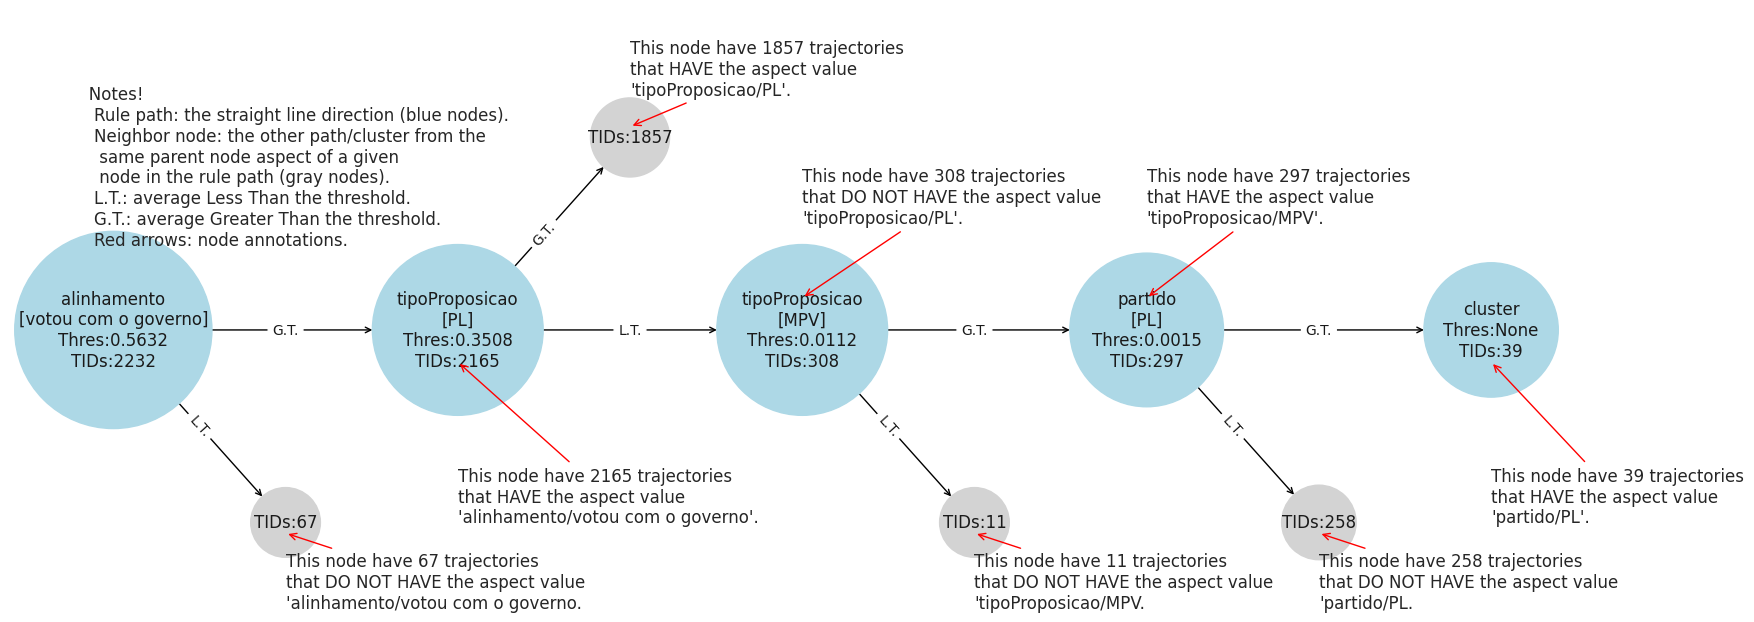

In [96]:
node_id = 'Lvl 5 - 0'

path = node_path(node_id, TreeNode.dendrogram_dict, TreeNode.threshold_nodes)
plot_graph_path(path)

## Check feature/percent/count

### help funcs

In [ ]:
def get_df_feature_gp(df, node_data, feature):

  tot_unique_tids = df['tid'].nunique()
  df_tot_and_cluster = df.groupby([feature])['tid'].nunique().reset_index(name='count_tot') \
                         .sort_values(by=['count_tot'], ascending=False)
  df_tot_and_cluster['percentage_tot'] = round((df_tot_and_cluster['count_tot'] / tot_unique_tids) * 100, 2)

  df_tmp = node_data.groupby([feature])['tid'].nunique().reset_index(name='count_node')
                                      #  .sort_values(by=[feature])
  df_tot_and_cluster = df_tot_and_cluster.merge(df_tmp, on=feature, how='left')
  df_tot_and_cluster['percentage_node'] = round((df_tot_and_cluster['count_node'] / tot_unique_tids) * 100, 4)

  del df_tmp

  return df_tot_and_cluster

In [ ]:
## test func
node = 'Lvl 5 - 5'
feature = 'partido'
tid_node = TreeNode.df_dict[node].index
node_data = df.loc[df['tid'].isin(tid_node)].copy()

get_df_feature_gp(df, node_data, feature)

In [ ]:
def hover_template(feature):
  return "<br>".join([f"x: {feature}", "y: %{y}%", "count: %{customdata[0]}"])

### Run

In [ ]:
# assign colors to type using a dictionary
colors = {'Global':'Red',
          'Node':'blue'}

# Create dropdown for node selection
node_dropdown = widgets.Dropdown(
    options=all_node_keys,
    value=all_node_keys[0],
    description="Node:",
)

# Create dropdowns for feature selection
feature1_dropdown = widgets.Dropdown(
    options=list(df.columns)[1:],
    value="partido",
    description="Feature 1:",
)

feature2_dropdown = widgets.Dropdown(
    options=list(df.columns)[1:],
    value="alinhamento",
    description="Feature 2:",
)
input_widgets = widgets.HBox([node_dropdown, feature1_dropdown, feature2_dropdown])#, layout=item_layout)
item_layout = widgets.Layout(margin='0 0 10px 0')
output = widgets.Output()
tab = widgets.Tab([output], layout=item_layout)

# Define callback function to update graphs
def update_graphs(node, feature1, feature2):
    output.clear_output()
    # Filter data based on selected node

    with output:
      tid_node = TreeNode.df_dict[node].index
      # node_data = TreeNode.df_dict[TreeNode.df_dict[node]]
      node_data = df.loc[df['tid'].isin(tid_node)].copy()

      print(f"Node: {node}; Is a cluster?: {'Yes' if node in node_clusters_keys else 'No'}")
      print(f"Number of tids: {node_data['tid'].nunique()}")
      print(f"Unique deputies: {node_data['parlamentar'].nunique()}")
      print(f"Unique labels: {node_data['partido'].nunique()}")
      # print(f"Labels: {node_data['label'].value_counts().to_dict()}")
      label_tid_list = node_data.groupby(['partido'])['tid'].nunique().reset_index(name='count_node') \
                                        .sort_values(by=['count_node'], ascending=False) \
                                        [['partido','count_node']].values
      label_tid = [str(l[0])+":"+str(l[1]) for l in label_tid_list]
      print(f"Labels: {label_tid}")
      # print()

      df_vis_ft1 = get_df_feature_gp(df, node_data, feature1)
      df_vis_ft2 = get_df_feature_gp(df, node_data, feature2)

      # print(f"{feature1}: {df_vis_ft1}")

      plot_ft1_1 = f"Feature-1: {feature1_dropdown.value} (Global)"
      plot_ft1_2 = f"Feature-1: {feature1_dropdown.value} (Node)"
      plot_ft2_1 = f"Feature-2: {feature2_dropdown.value} (Global)"
      plot_ft2_2 = f"Feature-2: {feature2_dropdown.value} (Node)"

      fig = make_subplots(rows=2, cols=2,
                          subplot_titles=(plot_ft1_1, plot_ft1_2,
                                          plot_ft2_1, plot_ft2_2,),
                          vertical_spacing=0.15,
                          # shared_yaxes=True,
                          # horizontal_spacing=0.05
                          )

      trace1 = go.Bar(
          x=list(df_vis_ft1[feature1].values),
          y=list(df_vis_ft1['percentage_tot'].values),
          customdata=np.transpose([list(df_vis_ft1['count_tot'].values)]),
          texttemplate="%{y:f.2}% (%{customdata[0]})",
          # text=list(df_vis_ft1['percentage_tot'].values),
          hovertemplate=hover_template(feature1),
          textposition='outside',
          name='Global', marker_color = colors['Global'], showlegend=False
      )
      trace2 = go.Bar(
          x=list(df_vis_ft1[feature1].values),
          y=list(df_vis_ft1['percentage_node'].values),
          customdata=np.transpose([list(df_vis_ft1['count_node'].values)]),
          texttemplate="%{y:f.2}% (%{customdata[0]})",
          hovertemplate=hover_template(feature1),
          textposition='outside',
          name='Node', marker_color = colors['Node'], showlegend=False
      )

      trace3 = go.Bar(
          x=list(df_vis_ft2[feature2].values),
          y=list(df_vis_ft2['percentage_tot'].values),
          customdata=np.transpose([list(df_vis_ft2['count_tot'].values)]),
          texttemplate="%{y:f.2}% (%{customdata[0]})",
          hovertemplate=hover_template(feature2),
          textposition='outside',
          name='Global',  marker_color = colors['Global'], showlegend=False
      )
      trace4 = go.Bar(
          x=list(df_vis_ft2[feature2].values),
          y=list(df_vis_ft2['percentage_node'].values),
          customdata=np.transpose([list(df_vis_ft2['count_node'].values)]),
          texttemplate="%{y:f.2}% (%{customdata[0]})",
          hovertemplate=hover_template(feature2),
          textposition='outside',
          name='Node', marker_color = colors['Node'], showlegend=False
      )

      fig.add_trace(trace1, row=1, col=1)
      fig.add_trace(trace2, row=1, col=2)
      fig.add_trace(trace3, row=2, col=1)
      fig.add_trace(trace4, row=2, col=2)

      # Update yaxis properties
      tickangle = -90
      y_title = "Percentage (%)"
      fig.update_yaxes(title_text=y_title, row=1, col=1)
      fig.update_xaxes(tickangle=tickangle, row=1, col=1)
      fig.update_yaxes(title_text=y_title, row=1, col=2)
      fig.update_xaxes(tickangle=tickangle, row=1, col=2)
      fig.update_yaxes(title_text=y_title, row=2, col=1)
      fig.update_xaxes(tickangle=tickangle, row=2, col=1)
      fig.update_yaxes(title_text=y_title, row=2, col=2)
      fig.update_xaxes(tickangle=tickangle, row=2, col=2)
      fig.update_layout(barmode="group",
                        plot_bgcolor="white",
                        width=1190,height=1000, xaxis_tickangle=tickangle

          )
      # Display figure
      # fig.show()
      display(fig)


def node_eventhandler(change):
    update_graphs(change.new, feature1_dropdown.value, feature2_dropdown.value)

def feature1_eventhandler(change):
    update_graphs(node_dropdown.value, change.new, feature2_dropdown.value)

def feature2_eventhandler(change):
    update_graphs(node_dropdown.value, feature1_dropdown.value, change.new)

# Connect callback function to dropdown selections
node_dropdown.observe(node_eventhandler, names="value")
feature1_dropdown.observe(feature1_eventhandler, names="value")
feature2_dropdown.observe(feature2_eventhandler, names="value")

# Display dropdowns

# display(widgets.VBox([node_dropdown, feature1_dropdown, feature2_dropdown], tab))
dashboard = widgets.VBox([input_widgets, tab])
display(dashboard)

# Initial call to display graphs with default values
update_graphs(all_node_keys[0], feature1_dropdown.value, feature2_dropdown.value)

## Trajetória

### help funcs

In [ ]:
def get_tids_partido(df, partido):
  return df[df['partido'] == partido]['tid'].unique()

### Run

In [ ]:
# assign colors to type using a dictionary
colors = {'Global':'Red',
          'Node':'blue'}

# Create dropdown for node selection
node_dropdown = widgets.Dropdown(
    options=all_node_keys,
    value=all_node_keys[0],
    description="Node:",
)

tid1_dropdown = widgets.Text(value="None", description='tid-1')#, disabled=True)

tid2_dropdown = widgets.Text(value="None", description='tid-2')#, disabled=True)

feature_dropdown = widgets.Dropdown(
    options=list(df.columns)[1:],
    value="partido",
    description="feature:",
)

input_widgets = widgets.HBox([node_dropdown, tid1_dropdown, tid2_dropdown, feature_dropdown])#, layout=item_layout)
item_layout = widgets.Layout(margin='0 0 10px 0')
output = widgets.Output()
tab = widgets.Tab([output], layout=item_layout)

# Define callback function to update graphs
def update_graphs(node, feature, tid1='None', tid2='None'):
    output.clear_output()
    with output:
      try:
        check_input = ['None','']
        if tid1.strip() not in check_input:
          tid1 = int(tid1)
        if tid2.strip() not in check_input:
          tid2 = int(tid2)
      except Exception as ex:
        print('Please, check the TIDs input ...\n')

      # Filter data based on selected node
      tid_node = TreeNode.df_dict[node].index
      # node_data = TreeNode.df_dict[TreeNode.df_dict[node]]
      node_data = df.loc[df['tid'].isin(tid_node)].copy()

      df_partido_tids = node_data.groupby(['partido'])['tid'].nunique().reset_index(name='qtd_tids') \
                                        .sort_values(by=['qtd_tids'], ascending=False)# \
                                        # [['partido','count_node']].values
      df_partido_tids['percent'] = round((df_partido_tids['qtd_tids'] / node_data['tid'].nunique()) * 100, 2)
      df_partido_tids['list_tids'] = df_partido_tids['partido'].apply(lambda x: get_tids_partido(node_data, x))

      print(f"Node: {node}; Is a cluster?: {'Yes' if node in node_clusters_keys else 'No'}")
      print(f"Number of tids: {node_data['tid'].nunique()}; ",end=' ')
      print(f"List of tids: {[str(row['partido'])+':'+str([n for n in row['list_tids']]) for index, row in df_partido_tids.iterrows()]}")
      print(f"Unique deputies: {node_data['parlamentar'].nunique()}")
      print(f"Voting period: from '{node_data['data'].min()}' to '{node_data['data'].max()}'")
      print(f"Unique labels: {node_data['partido'].nunique()}")
      print(f"Parties: {[str(row['partido'])+': (qtd_tids='+str(row['qtd_tids'])+', porcentagem='+str(row['percent'])+')' for index, row in df_partido_tids.iterrows()]}")

      try:
        # print(f"node:{node}, tid1:{tid1}, tid2:{tid2}, feature:{feature}")
        df_tid1 = node_data[node_data['tid'] == tid1].copy().reset_index(drop=True) if tid1 not in check_input else pd.DataFrame()
        df_tid2 = node_data[node_data['tid'] == tid2].copy().reset_index(drop=True) if tid2 not in check_input else pd.DataFrame()

        # print(f"df_tid1:{df_tid1.head()}")
        # print(f"df_tid2:{df_tid2.head()}")

        df_tids = pd.concat([df_tid1, df_tid2])#, ignore_index=True)

        fig = go.Figure()
        tid_count = 0
        for tid in df_tids['tid'].unique():
          x = list()
          tmp = df_tids[df_tids['tid'] == tid].index
          for i in range(len(tmp)):
            if i == 0:
              x.append(tmp[i])
            else:
              x.append(x[i-1]+5)
          tid_count += 1
          fig.add_trace(
                        go.Scatter(name=str(tid),
                                  #  x=df_tmp[df_tmp['tid'] == tid].index,
                                  x=x,
                                  y=list([tid_count])*df_tids[df_tids['tid'] == tid].shape[0],
                                  mode="markers+text",
                                  text=df_tids[df_tids['tid'] == tid][feature],
                                  textposition="bottom center"
                                  )
                        )

        fig.update_yaxes(visible=False)#, showticklabels=False)
        fig.update_xaxes(visible=False)#, showticklabels=False)

        fig.update_layout(plot_bgcolor="white",
                          width=2000, height=300,# xaxis_tickangle=-45
                          legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left",
                                      x=0.01, title="TIDs:"),
                          margin=dict(l=0, r=0, t=0, b=5)
                          )
        display(fig)

      except Exception as ex:
        print("\nWaiting inputs ...")


def node_eventhandler(change):
    update_graphs(change.new, feature_dropdown.value, tid1_dropdown.value, tid2_dropdown.value)

def feature_eventhandler(change):
    update_graphs(node_dropdown.value, change.new, tid1_dropdown.value, tid2_dropdown.value)

def tid1_eventhandler(change):
    update_graphs(node_dropdown.value, feature_dropdown.value, change.new, tid2_dropdown.value)

def tid2_eventhandler(change):
    update_graphs(node_dropdown.value, feature_dropdown.value, tid1_dropdown.value, change.new)

# Connect callback function to dropdown selections
node_dropdown.observe(node_eventhandler, names="value")
feature_dropdown.observe(feature_eventhandler, names="value")
tid1_dropdown.observe(tid1_eventhandler, names="value")
tid2_dropdown.observe(tid2_eventhandler, names="value")

# Display dropdowns

# display(widgets.VBox([node_dropdown, feature1_dropdown, feature2_dropdown], tab))
dashboard = widgets.VBox([input_widgets, tab])
display(dashboard)

# Initial call to display graphs with default values
update_graphs(all_node_keys[0], feature_dropdown.value, tid1_dropdown.value, tid2_dropdown.value)